In [1]:
import numpy as np
import gymnasium as gym
from noisyenv.wrappers import RandomNormalNoisyObservation
import matplotlib.pyplot as plt
# import gym
import d4rl



No module named 'flow'
/home/ubuntu/miniconda3/envs/mopo/lib/python3.8/site-packages/glfw/__init__.py:917: GLFWError: (65550) b'X11: The DISPLAY environment variable is missing'
  warnings.warn(message, GLFWError)
No module named 'carla'
pybullet build time: Jan 29 2025 23:19:57


In [2]:
import gym
import d4rl
import pickle
import os

In [4]:
# base_env = gym.make("Hopper-v2")
# env = RandomNormalNoisyObservation(env=base_env, noise_rate=1, loc = 0.0, scale=0.001)

/home/ubuntu/miniconda3/envs/mopo/lib/python3.8/site-packages/gym/envs/registration.py:505: UserWarning: WARN: The environment Hopper-v2 is out of date. You should consider upgrading to version `v3` with the environment ID `Hopper-v3`.
  logger.warn(


AssertionError: 

In [55]:
observation, info = env.reset(seed=333)
observation_b, info_b = base_env.reset(seed=333)
noisy_data = {'observation': [], 'action': [], 'reward': [], 'next_observation': [], 'terminal': []}
data = {'observation': [], 'action': [], 'reward': [], 'next_observation': [], 'terminal': []}
for _ in range(100):
    action = env.action_space.sample()
    next_observation, reward, terminated, truncated, info = env.step(action)
    next_observation_b, reward_b, terminated_b, truncated_b, info_b = base_env.step(action)

    noisy_data['observation'].append(observation)
    noisy_data['action'].append(action)
    noisy_data['reward'].append([reward])
    noisy_data['next_observation'].append(next_observation)
    noisy_data['terminal'].append([terminated])

    data['observation'].append(observation_b)
    data['action'].append(action)
    data['reward'].append([reward_b])
    data['next_observation'].append(next_observation_b)
    data['terminal'].append([terminated_b])
    observation = next_observation
    observation_b = next_observation_b
    if terminated or truncated:
        observation, info = env.reset()
        observation_b, info_b = base_env.reset()
        # break #get one full episode only
    
noisy_data = {
            key: np.concatenate(noisy_data[key], axis=0)
            for key in noisy_data.keys()
        }
data = {
            key: np.concatenate(data[key], axis=0)
            for key in data.keys()
        }
noisy_data['next_observation'] = noisy_data['next_observation'].reshape(-1, next_observation_b.shape[0])
data['next_observation'] = data['next_observation'].reshape(-1, next_observation_b.shape[0])


noisy_data['observation'] = noisy_data['observation'].reshape(-1, observation_b.shape[0])
data['observation'] = data['observation'].reshape(-1, observation_b.shape[0])

noisy_data['action'] = noisy_data['action'].reshape(-1, action.shape[0])
data['action'] = data['action'].reshape(-1, action.shape[0])

env.close()
base_env.close()

In [56]:
next_observation_b.shape

(11,)

In [11]:
def plot_features(data_noisy, data, title = '', label1='', label2=''):
    #plot histograms of all features in data
    num_features = data.shape[1]
    num_rows = int(np.ceil(num_features / 3))
    fig, axs = plt.subplots(num_rows, 3, figsize=(15, num_rows * 3))
    axs = axs.flatten()
    for i in range(num_features):
        # axs[i].hist(data_noisy[:, i], bins=100, alpha=0.7, color='orange', label ="noisy")
        # axs[i].hist(data[:, i], bins=100, alpha=0.7, color='blue', label = "no noise")
        
        axs[i].hist(data_noisy[:, i], bins=100, alpha=0.7, color='orange', label =label1)
        axs[i].hist(data[:, i], bins=100, alpha=0.7, color='blue', label = label2)
        
        axs[i].set_title(f'Feature {i}')
        axs[i].set_xlabel('Value')
        axs[i].set_ylabel('Frequency')
        axs[i].legend()
    fig.suptitle(title)
    plt.tight_layout()
    plt.show()

In [60]:
class RandomNormalNoisyActions(gym.ActionWrapper):
    """Adds random Normal noise to the observations of the environment.

    Example:
        >>> import gymnasium as gym
        >>> from noisyenv.wrappers import RandomNormalNoisyObservation
        >>> env = gym.make("CartPole-v1")
        >>> wrapped_env = RandomNormalNoisyObservation(env, noise_rate=0.1, loc=0.0, scale=0.1)
    """

    def __init__(self, env, noise_rate=0.01, loc=0.0, scale=0.01):
        """Initializes the :class:`RandomNormalNoisyObservation` wrapper.

        Args:
            env (gym.Env): The environment to apply the wrapper
            noise_rate (float, optional): Probability of adding noise to the observation each step.
                Defaults to 0.01.
            loc (float, optional): Mean ("centre") of the noise distribution.
                Defaults to 0.0.
            scale (float, optional): Standard deviation (spread or "width") of the noise distribution.
                Must be non-negative. Defaults to 0.01.
        """
        super().__init__(env)
        self.noise_rate = noise_rate
        self.loc = loc
        self.scale = scale

    def action(self, action):
        """Modify the action by adding noise with some probability."""
        if np.random.rand() <= self.noise_rate:
            noise = np.random.normal(loc=self.loc, scale=self.scale, size=action.shape)
            action = action + noise
            # Clip to ensure action remains valid
            action = np.clip(action, self.env.action_space.low, self.env.action_space.high)
        return action

In [61]:

env_act = RandomNormalNoisyActions(env=base_env, noise_rate=1, loc = 0.0, scale=0.001)
observation, info = env_act.reset(seed=333)
observation_b, info_b = base_env.reset(seed=333)
noisy_data = {'observation': [], 'action': [], 'reward': [], 'next_observation': [], 'terminal': []}
data = {'observation': [], 'action': [], 'reward': [], 'next_observation': [], 'terminal': []}
for _ in range(100):

    #when SAC comes, sample from the policy
    action = env_act.action_space.sample()
    action_b = base_env.action_space.sample()
    next_observation, reward, terminated, truncated, info = env_act.step(action)
    next_observation_b, reward_b, terminated_b, truncated_b, info_b = base_env.step(action_b)

    noisy_data['observation'].append(observation)
    noisy_data['action'].append(action)
    noisy_data['reward'].append([reward])
    noisy_data['next_observation'].append(next_observation)
    noisy_data['terminal'].append([terminated])

    data['observation'].append(observation_b)
    data['action'].append(action_b)
    data['reward'].append([reward_b])
    data['next_observation'].append(next_observation_b)
    data['terminal'].append([terminated_b])
    observation = next_observation
    observation_b = next_observation_b
    if terminated or truncated:
        observation, info = env.reset()
        observation_b, info_b = base_env.reset()
        # break #get one full episode only
    
noisy_data = {
            key: np.concatenate(noisy_data[key], axis=0)
            for key in noisy_data.keys()
        }
data = {
            key: np.concatenate(data[key], axis=0)
            for key in data.keys()
        }
noisy_data['next_observation'] = noisy_data['next_observation'].reshape(-1, next_observation_b.shape[0])
data['next_observation'] = data['next_observation'].reshape(-1, next_observation_b.shape[0])

noisy_data['observation'] = noisy_data['observation'].reshape(-1, observation_b.shape[0])
data['observation'] = data['observation'].reshape(-1, observation_b.shape[0])

noisy_data['action'] = noisy_data['action'].reshape(-1, action.shape[0])
data['action'] = data['action'].reshape(-1, action.shape[0])

env.close()
base_env.close()

In [67]:
noisy_data['terminal'].shape

(100,)

## multiplied noise 0.001

In [4]:
import os

# env = gym.make("Hopper-v2")
offline_env = gym.make('hopper-expert-v2')
data = d4rl.qlearning_dataset(offline_env)
# noisy_env = RandomNormalNoisyActions(env=env, noise_rate=0.01, loc = 0.0, scale = 0.001)
#load data




/home/ubuntu/miniconda3/envs/mopo/lib/python3.8/site-packages/gym/spaces/box.py:78: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")
load datafile:   0%|          | 0/21 [00:00<?, ?it/s]

load datafile: 100%|██████████| 21/21 [00:01<00:00, 17.84it/s]


In [10]:
logdir = os.path.join('/abiomed/intermediate_data_d4rl', 'sac_expert', f"Hopper-v2_action_noisy.pkl") 
with open(logdir, 'rb') as f:
    data_noisy_mul = pickle.load(f)

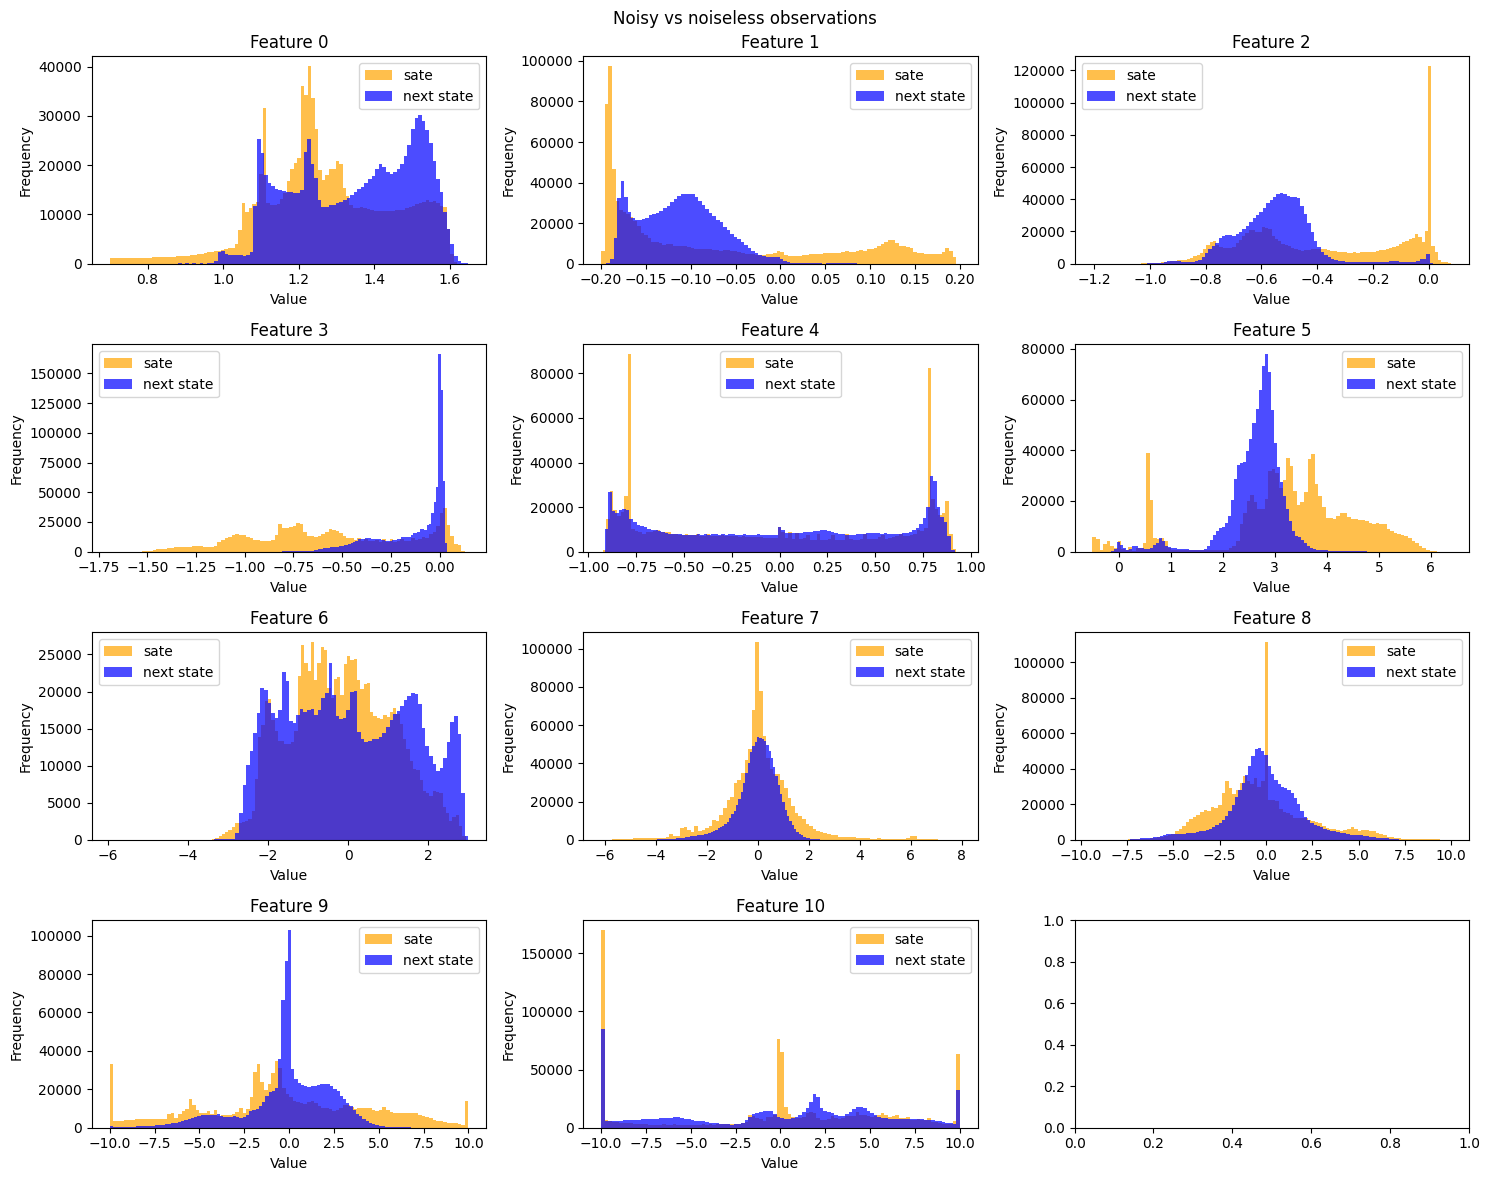

In [8]:
plot_features(data_noisy_mul['observation'], data['observations'], title = 'Noisy vs noiseless observations')

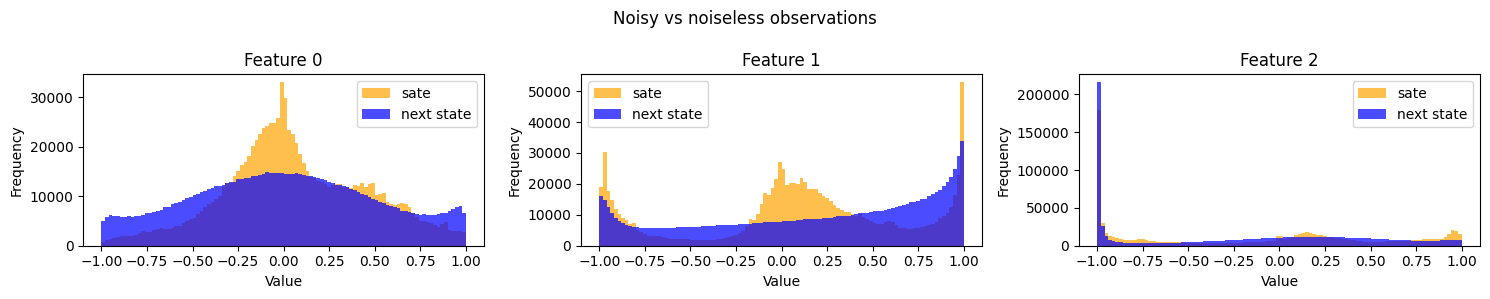

In [9]:
plot_features(data_noisy_mul['action'], data['actions'], title = 'Noisy vs noiseless observations')

## added 0.001 noise

In [11]:
logdir = os.path.join('/abiomed/intermediate_data_d4rl', 'sac_expert', f"Hopper-v2_action_noisy_added.pkl") 
with open(logdir, 'rb') as f:
    data_noisy_add_0001 = pickle.load(f)

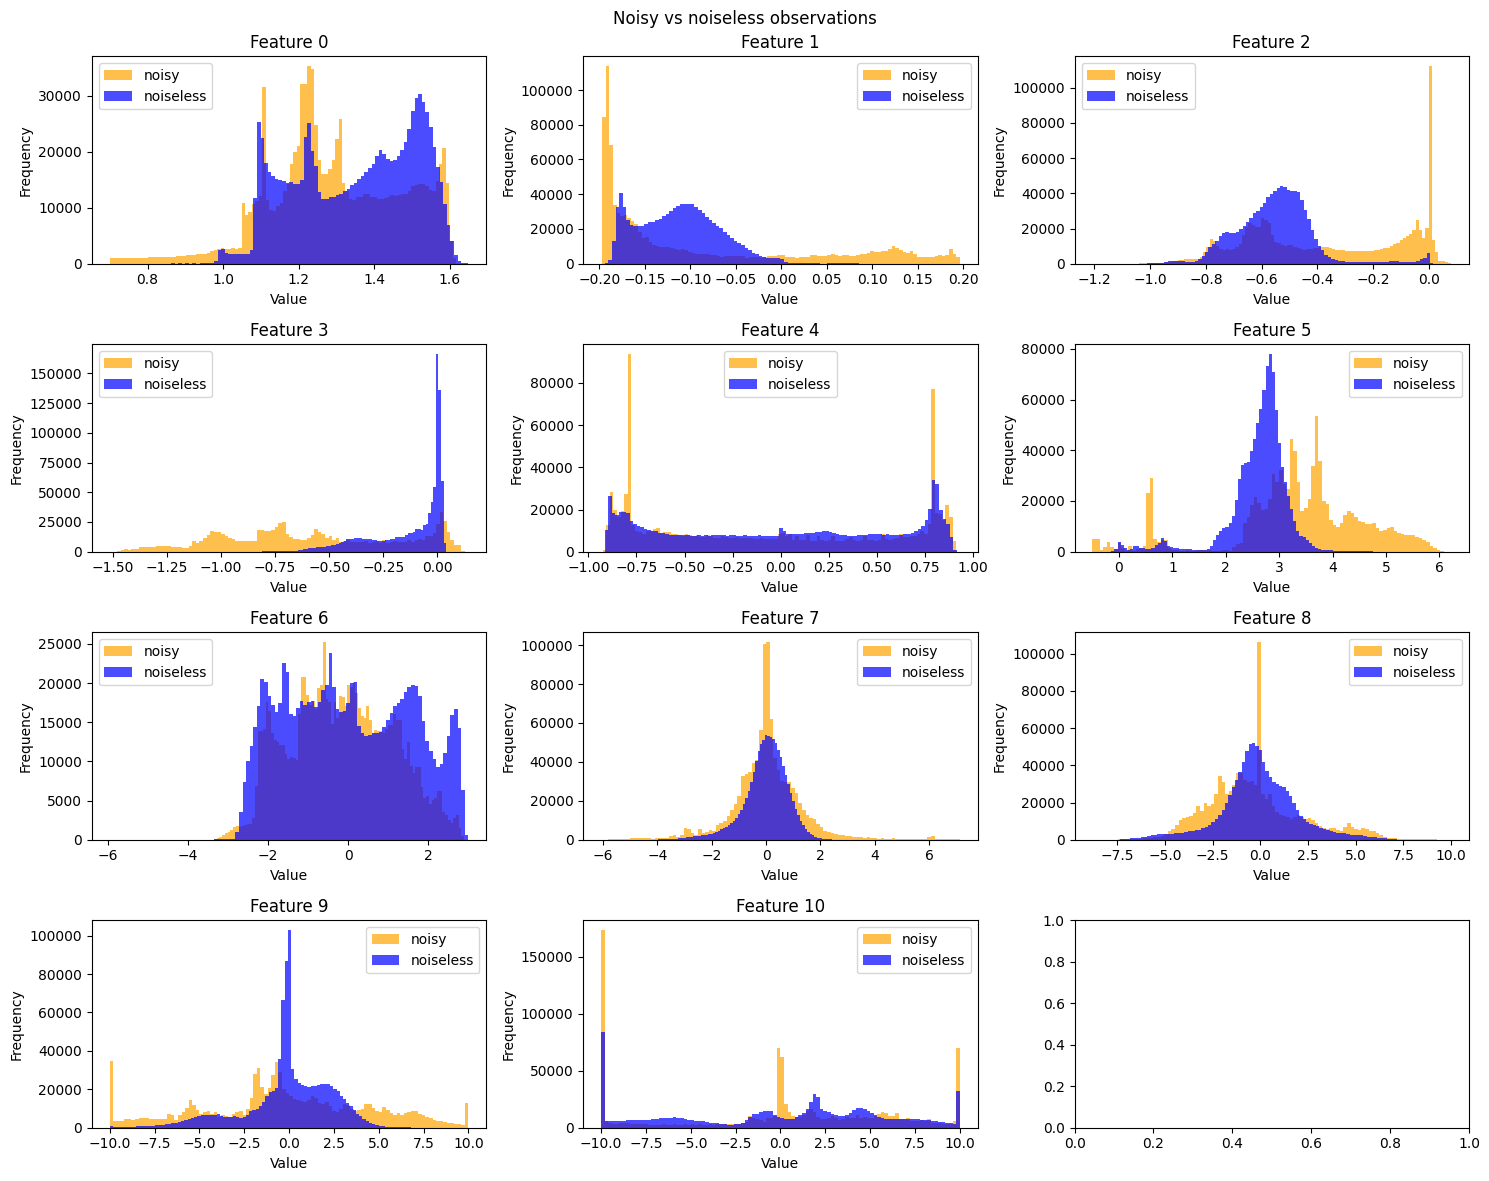

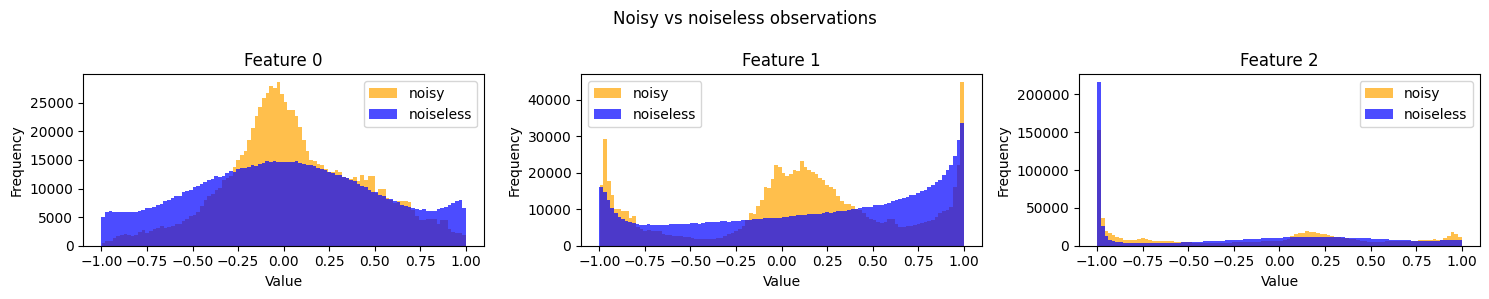

In [7]:
plot_features(data_noisy_add_0001['observation'], data['observations'], title = 'Noisy vs noiseless observations')
plot_features(data_noisy_add_0001['action'], data['actions'], title = 'Noisy vs noiseless observations')

## added noise 0.0005

In [12]:
offline_env = gym.make('hopper-expert-v2')
data = d4rl.qlearning_dataset(offline_env)
# noisy_env = RandomNormalNoisyActions(env=env, noise_rate=0.01, loc = 0.0, scale = 0.001)
#load data
logdir = os.path.join('/abiomed/intermediate_data_d4rl', 'sac_expert', f"Hopper-v2_action_noisy_added_0.0005.pkl") 
with open(logdir, 'rb') as f:
    data_noisy_added_00005 = pickle.load(f)

/home/ubuntu/miniconda3/envs/mopo/lib/python3.8/site-packages/gym/spaces/box.py:78: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")
load datafile:  10%|▉         | 2/21 [00:00<00:01, 18.79it/s]

load datafile: 100%|██████████| 21/21 [00:01<00:00, 17.38it/s]


## added no noise

In [3]:

# noisy_env = RandomNormalNoisyActions(env=env, noise_rate=0.01, loc = 0.0, scale = 0.001)
#load data
logdir = os.path.join('/abiomed/intermediate_data_d4rl', 'sac_expert', f"Hopper-v2_action_noisy_added_0.001_0.0.pkl") 
with open(logdir, 'rb') as f:
    data_no_noisy = pickle.load(f)

In [4]:
logdir

'/abiomed/intermediate_data_d4rl/sac_expert/Hopper-v2_action_noisy_added_0.001_0.0.pkl'

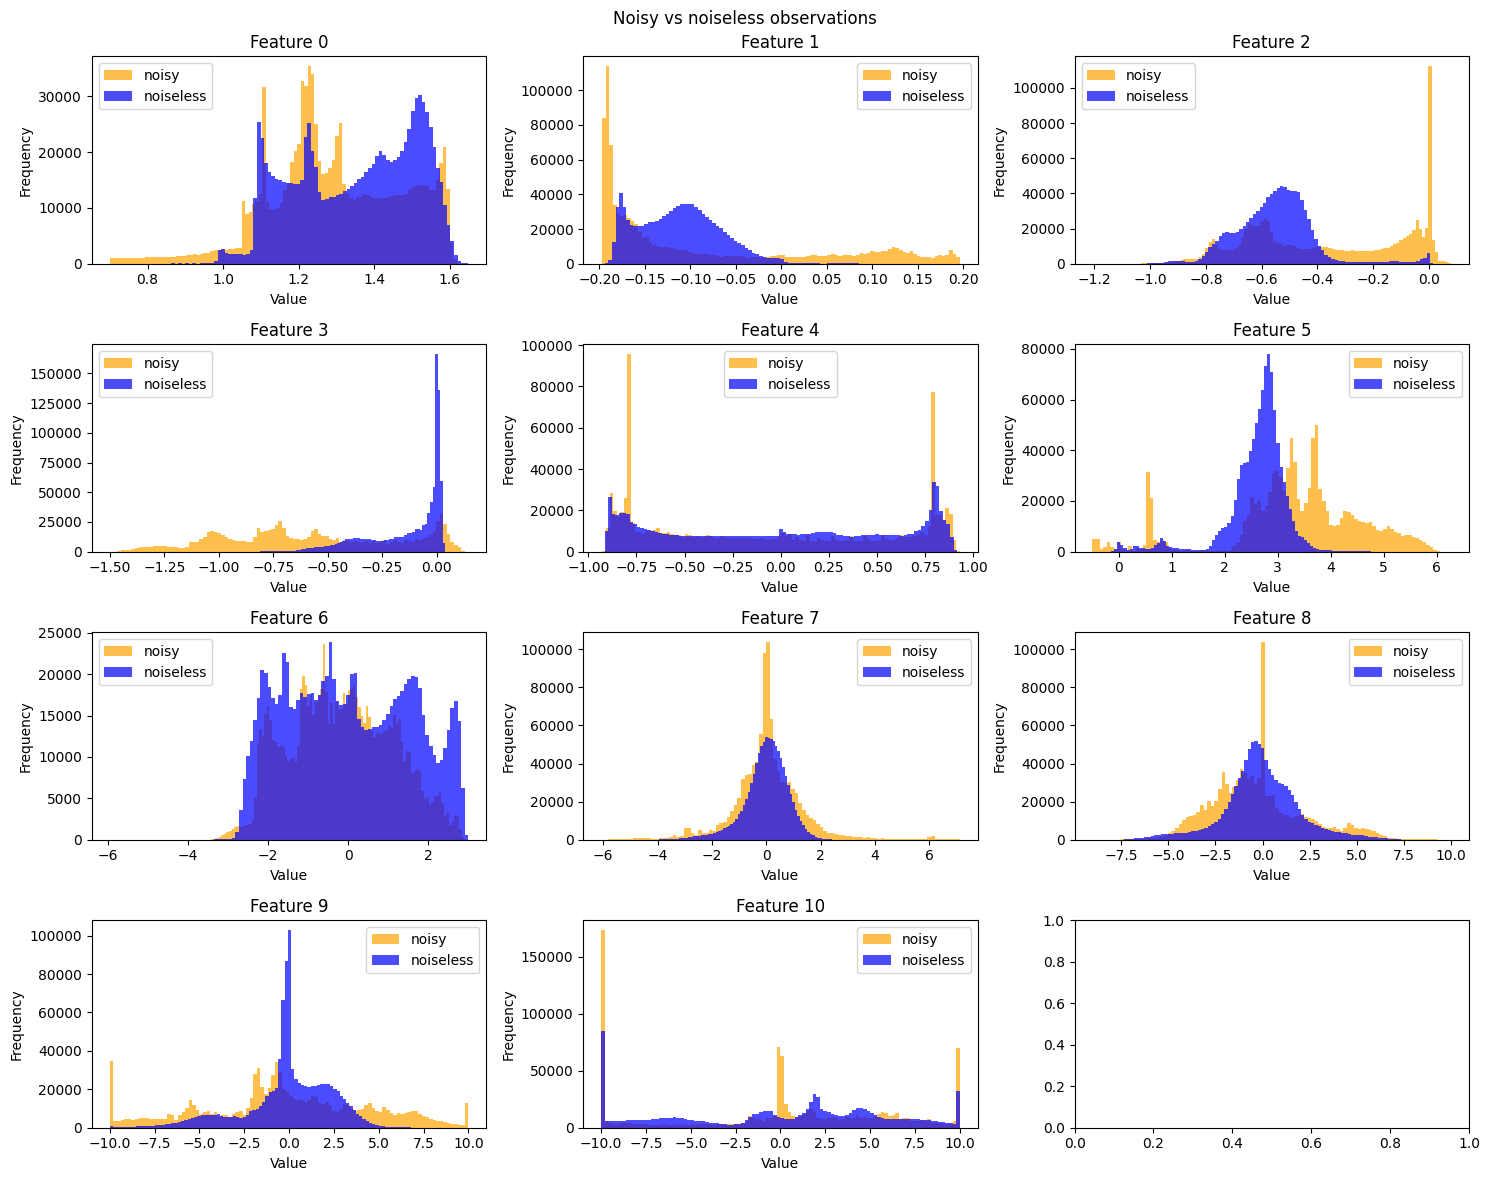

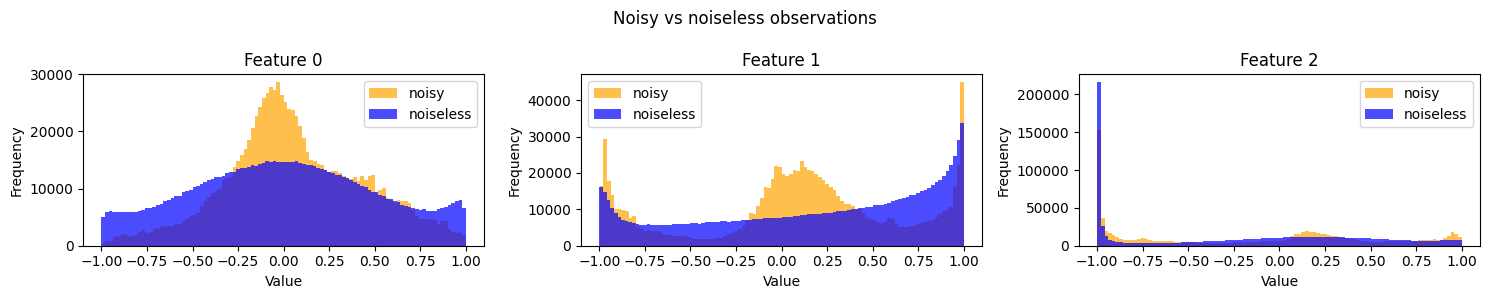

In [8]:
plot_features(data_no_noisy['observation'], data['observations'], title = 'Noisy vs noiseless observations')
plot_features(data_no_noisy['action'], data['actions'], title = 'Noisy vs noiseless observations')

In [5]:
data_no_noisy['observations'] = data_no_noisy['observation']
data_no_noisy['actions'] = data_no_noisy['action']
data_no_noisy['next_observations'] = data_no_noisy['next_observation']
data_no_noisy['rewards'] = data_no_noisy['reward']
data_no_noisy['terminals'] = data_no_noisy['terminal']

#save
logdir = "/abiomed/intermediate_data_d4rl/sac_expert/Hopper-v2_action_noisy_added_0.001_0.0.pkl"
with open(logdir, 'wb') as f:
    pickle.dump(data_no_noisy, f)



##  our expert vs 0.0005 added noise

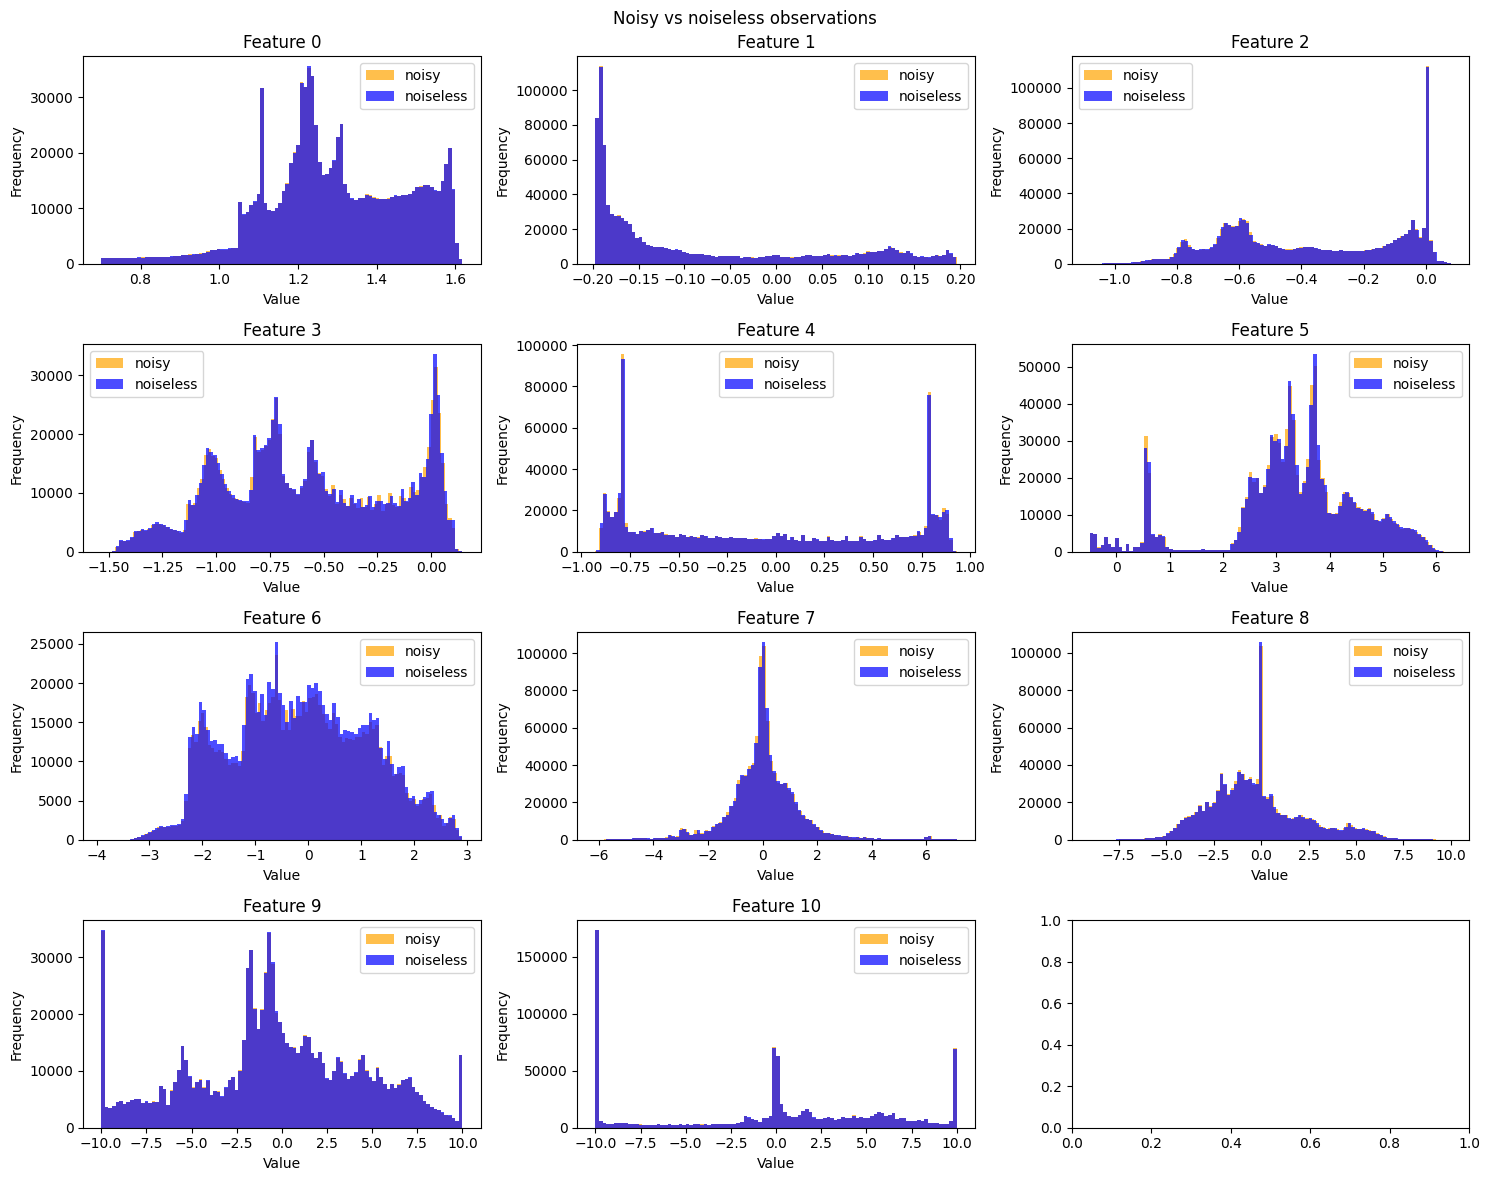

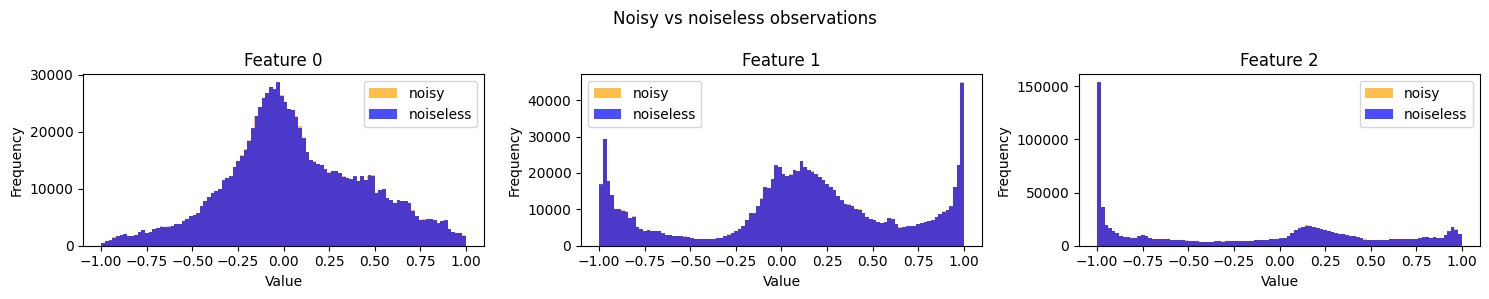

In [15]:
plot_features(data_no_noisy['observation'], data_noisy_added_00005['observation'], title = 'Noisy vs noiseless observations')
plot_features(data_no_noisy['action'], data_noisy_added_00005['action'], title = 'Noisy vs noiseless observations')

## our expert vs 0.001 noise added

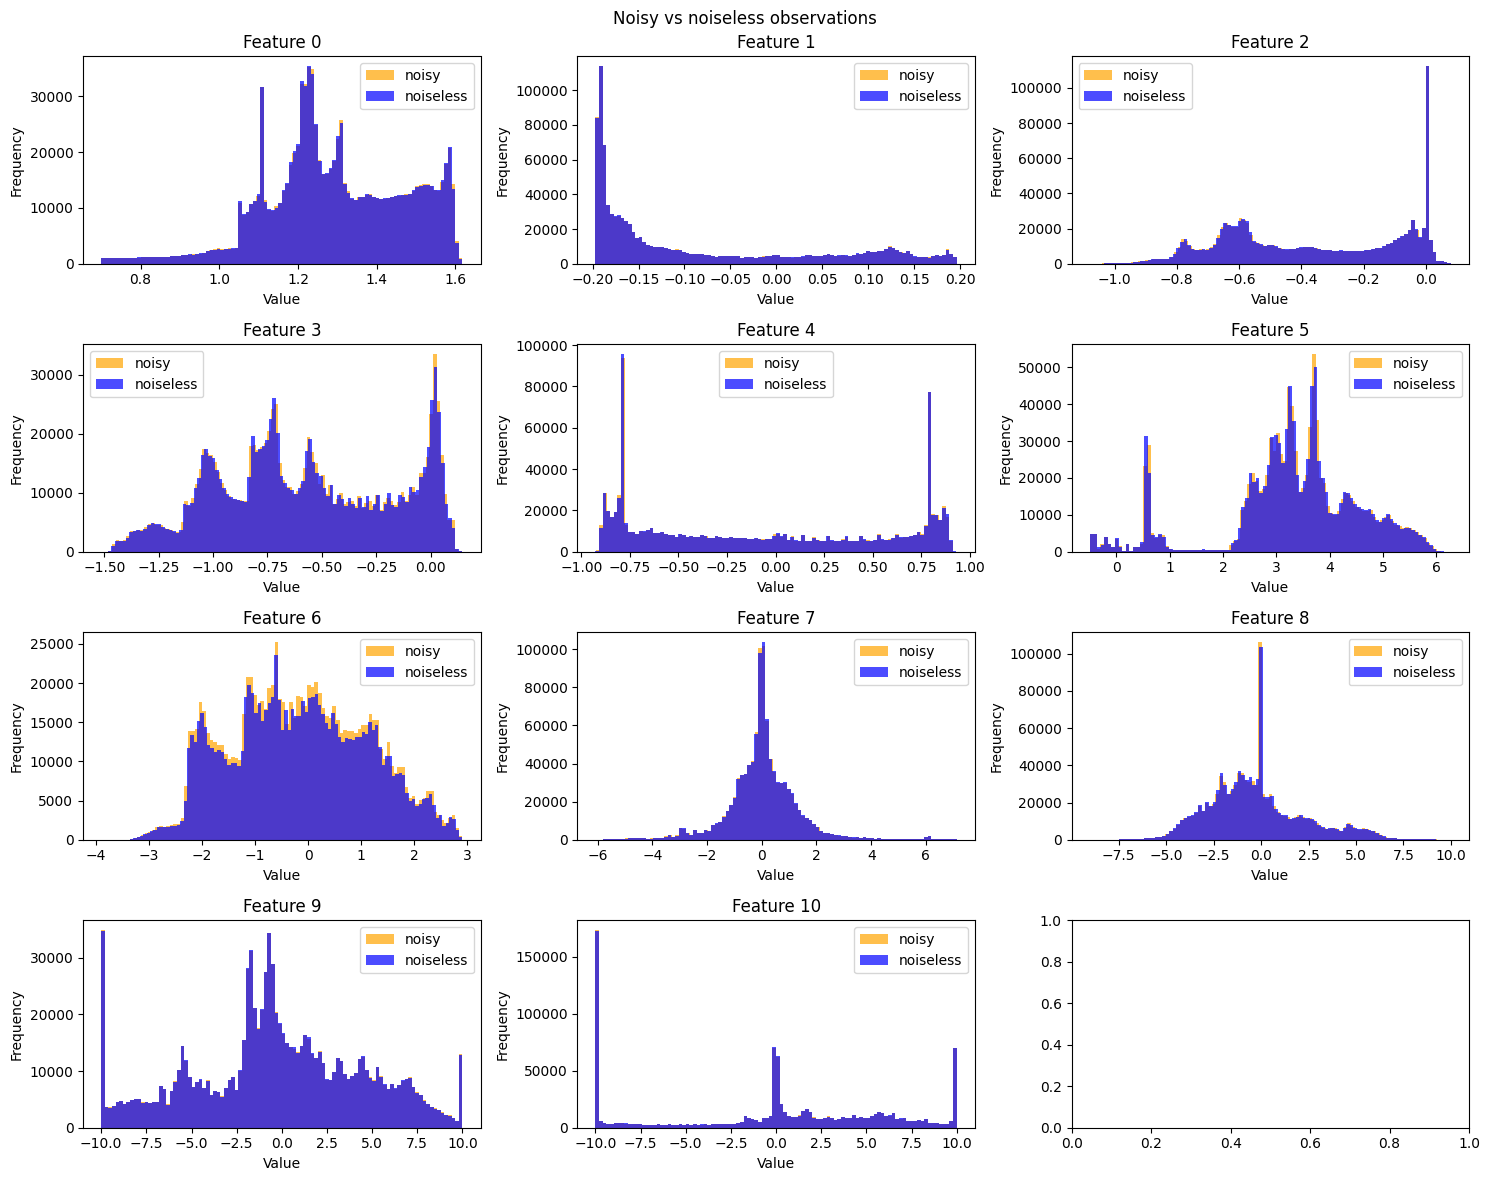

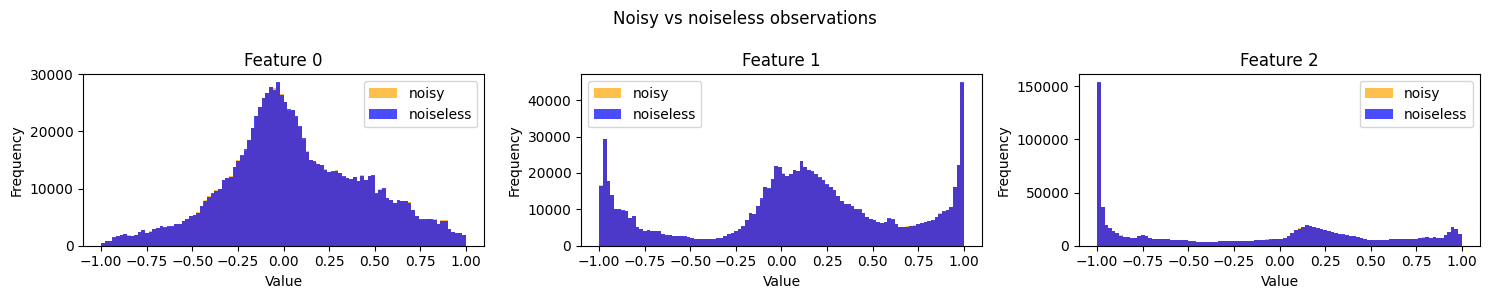

In [20]:
plot_features(data_noisy_add_0001['observation'], data_no_noisy['observation'], title = 'Noisy vs noiseless observations')
plot_features( data_noisy_add_0001['action'], data_no_noisy['action'],title = 'Noisy vs noiseless observations')

## Multiplied vs 0.001 multiplied noise

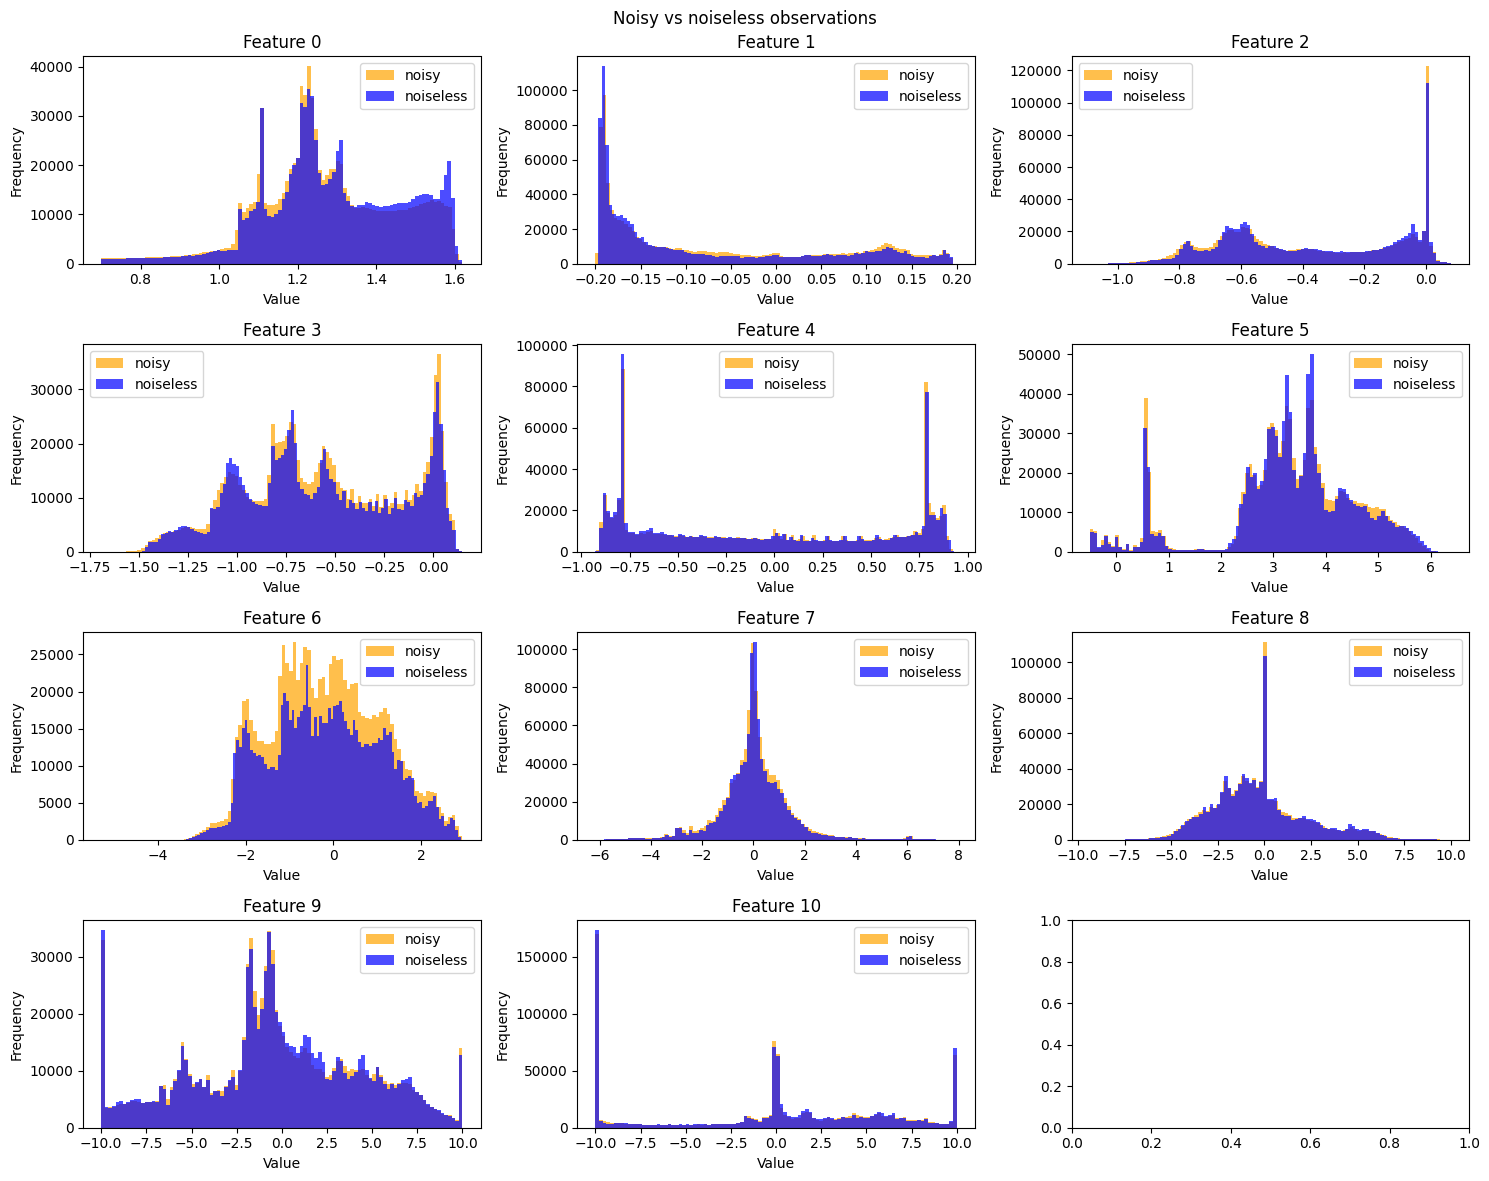

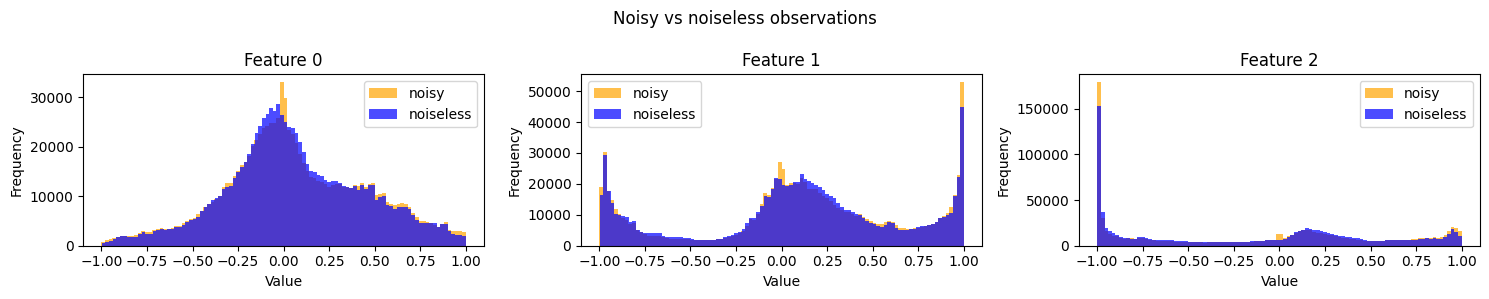

In [19]:
plot_features( data_noisy_mul['observation'], data_no_noisy['observation'],title = 'Noisy vs noiseless observations')
plot_features(data_noisy_mul['action'], data_no_noisy['action'], title = 'Noisy vs noiseless observations')

In [ ]:
/abiomed/intermediate_data_d4rl/sac_expert/Hopper-v2_action_noisy_added_0.001_0.1.pkl

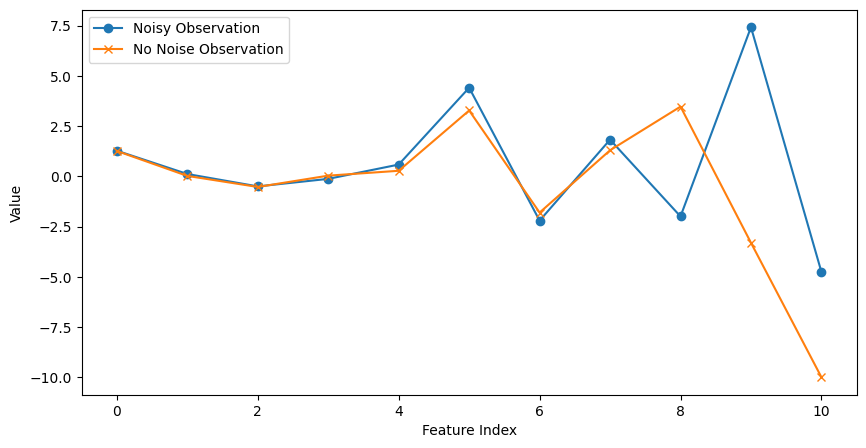

In [49]:

#plot one sample from the predicted next_observations ande eval_Data

sample_idx = 260
sample_pred = data_noisy_mul['observation'][sample_idx]
sample_gt = data_no_noisy['observation'][sample_idx]
plt.figure(figsize=(10, 5))
plt.plot(sample_pred, label='Noisy Observation', marker='o')
plt.plot(sample_gt, label='No Noise Observation', marker='x')
# plt.title('Sample Predicted vs Ground Truth Next Observation')
plt.xlabel('Feature Index')
plt.ylabel('Value')
plt.legend()
plt.show()


## increase the noise rate 

In [21]:

logdir = "/abiomed/intermediate_data_d4rl/sac_expert/Hopper-v2_action_noisy_added_0.001_0.1.pkl"
with open(logdir, 'rb') as f:
    data_noisy_0001_001 = pickle.load(f)

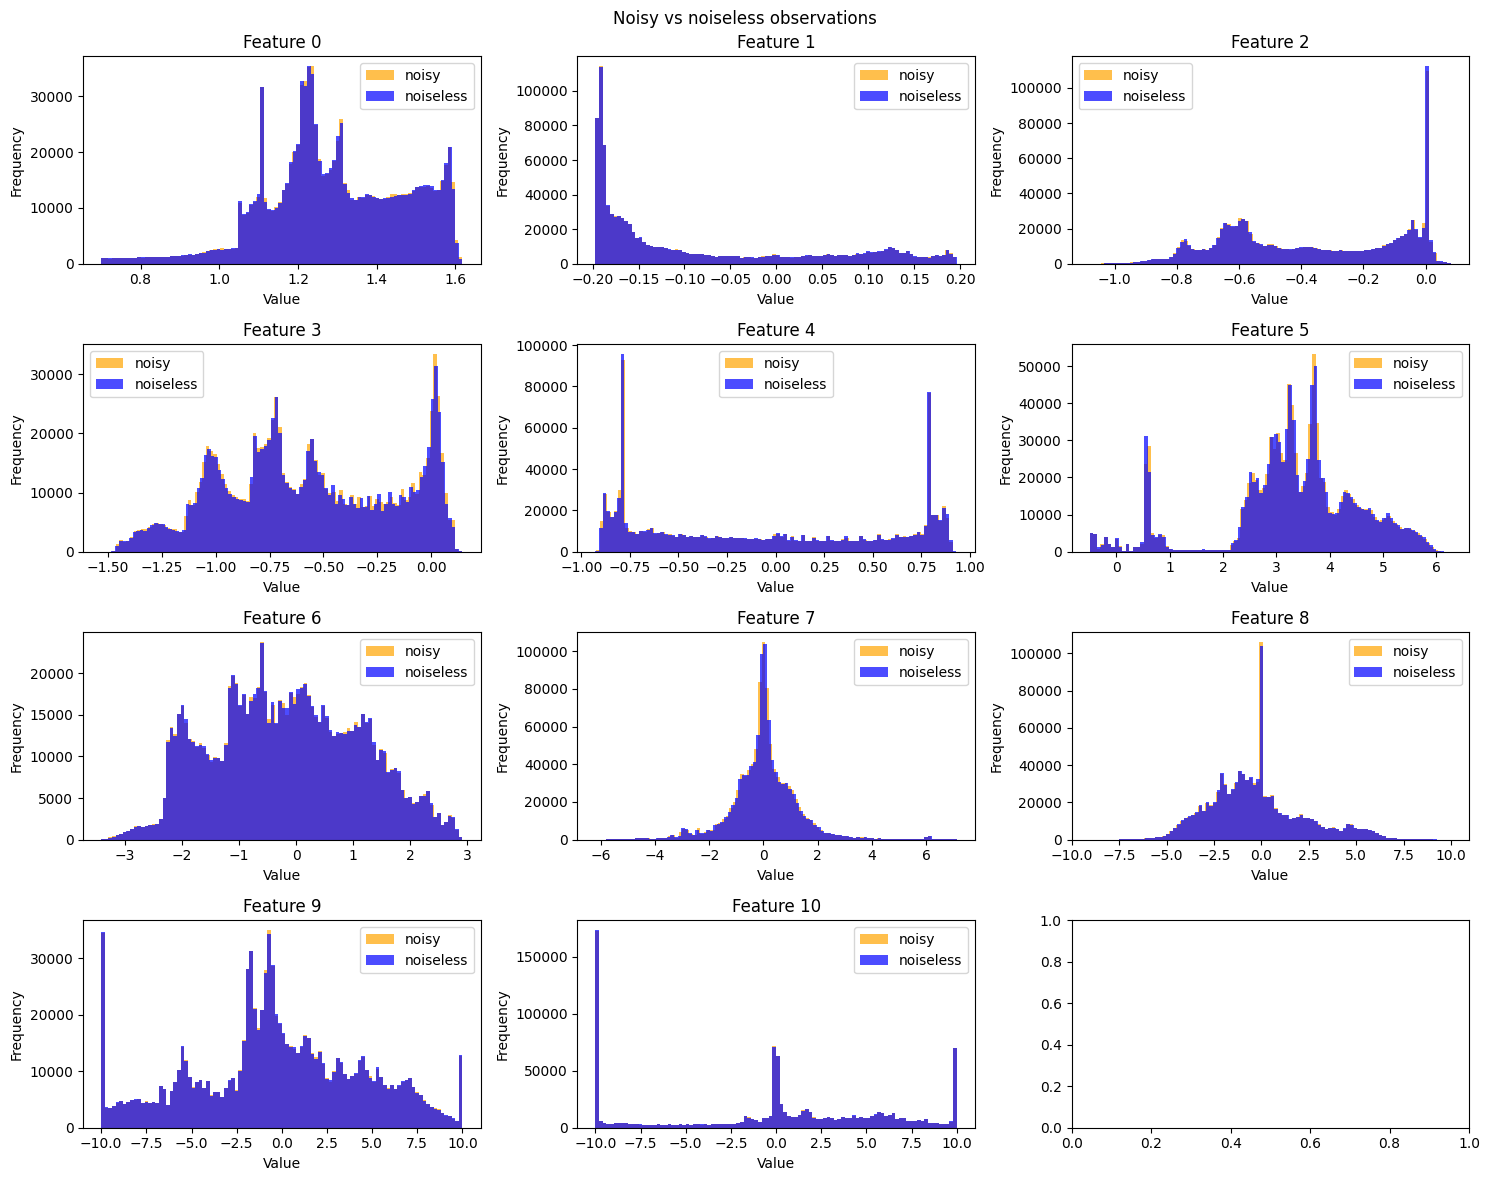

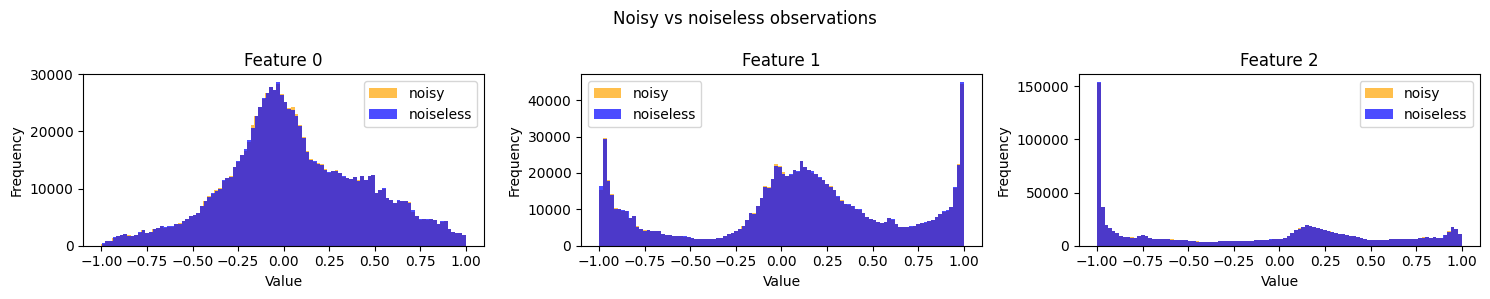

In [22]:
plot_features( data_noisy_0001_001['observation'], data_no_noisy['observation'],title = 'Noisy vs noiseless observations')
plot_features(data_noisy_0001_001['action'], data_no_noisy['action'], title = 'Noisy vs noiseless observations')

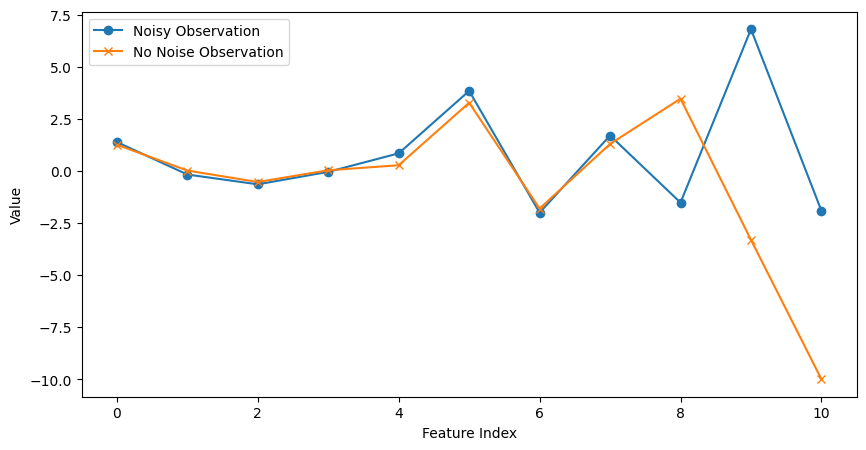

In [48]:

#plot one sample from the predicted next_observations ande eval_Data

sample_idx = 260
sample_pred = data_noisy_0001_001['observation'][sample_idx]
sample_gt = data_no_noisy['observation'][sample_idx]
plt.figure(figsize=(10, 5))
plt.plot(sample_pred, label='Noisy Observation', marker='o')
plt.plot(sample_gt, label='No Noise Observation', marker='x')
# plt.title('Sample Predicted vs Ground Truth Next Observation')
plt.xlabel('Feature Index')
plt.ylabel('Value')
plt.legend()
plt.show()


## increase the noise magnitude

In [23]:


logdir = "/abiomed/intermediate_data_d4rl/sac_expert/Hopper-v2_action_noisy_added_0.01_0.01.pkl"
with open(logdir, 'rb') as f:
    data_noisy_001_001 = pickle.load(f)

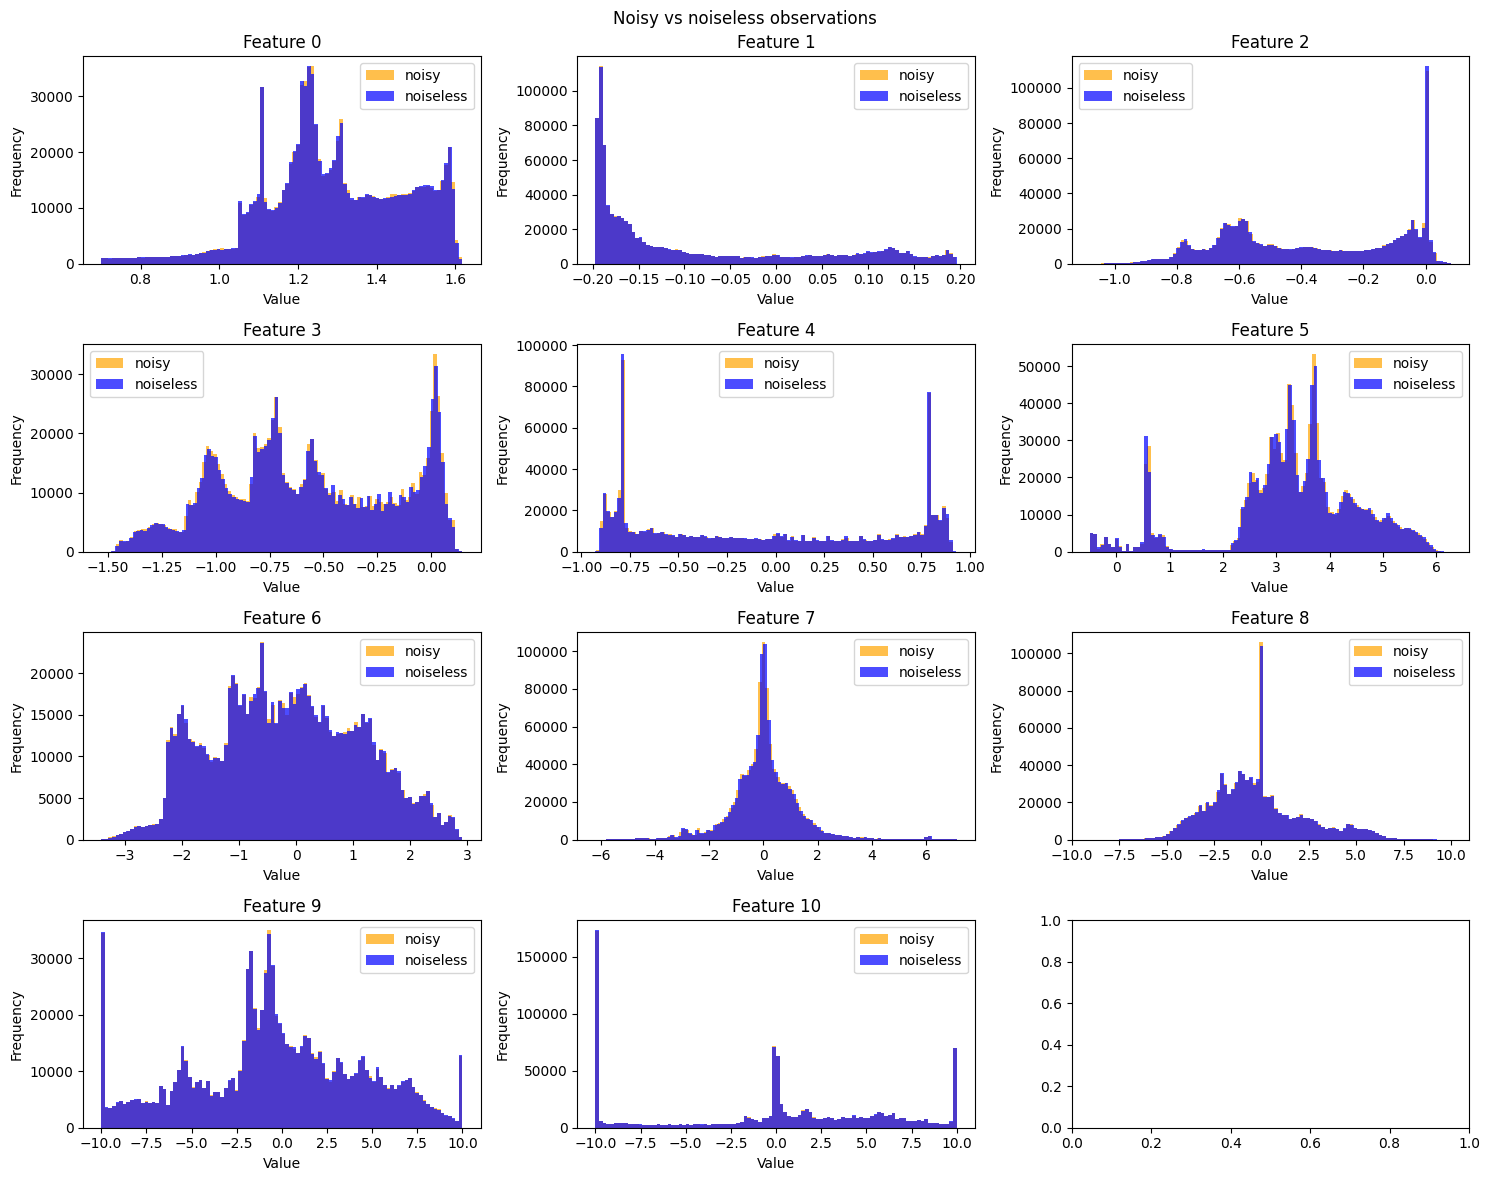

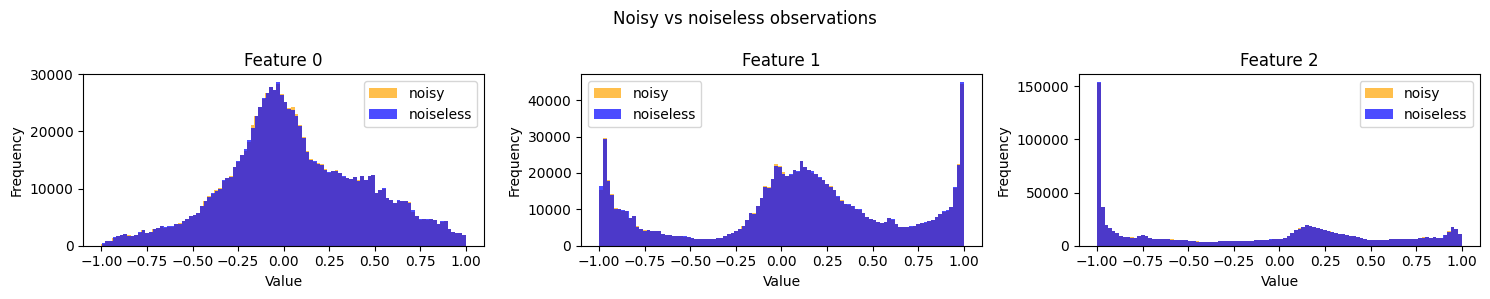

In [24]:
plot_features( data_noisy_0001_001['observation'], data_no_noisy['observation'],title = 'Noisy vs noiseless observations')
plot_features(data_noisy_0001_001['action'], data_no_noisy['action'], title = 'Noisy vs noiseless observations')

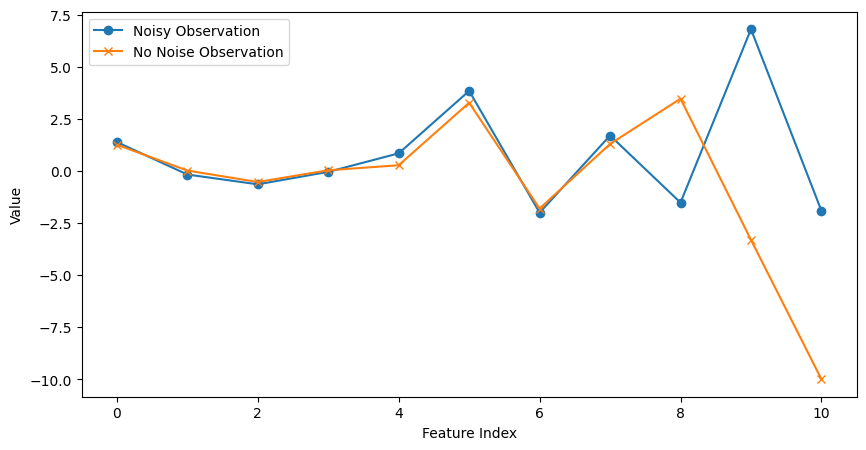

In [47]:

#plot one sample from the predicted next_observations ande eval_Data

sample_idx = 260
sample_pred = data_noisy_0001_001['observation'][sample_idx]
sample_gt = data_no_noisy['observation'][sample_idx]
plt.figure(figsize=(10, 5))
plt.plot(sample_pred, label='Noisy Observation', marker='o')
plt.plot(sample_gt, label='No Noise Observation', marker='x')
# plt.title('Sample Predicted vs Ground Truth Next Observation')
plt.xlabel('Feature Index')
plt.ylabel('Value')
plt.legend()
plt.show()


## noise rate=1 noise magnitude=0.001

logdir = "/abiomed/intermediate_data_d4rl/sac_expert/Hopper-v2_action_noisy_added_0.01_.pkl"
with open(logdir, 'rb') as f:
    data_noisy_001_001 = pickle.load(f)

In [37]:
logdir = "/abiomed/intermediate_data_d4rl/sac_expert/Hopper-v2_action_noisy_added_0.001_1.0.pkl"
with open(logdir, 'rb') as f:
    data_noisy_001_1 = pickle.load(f)

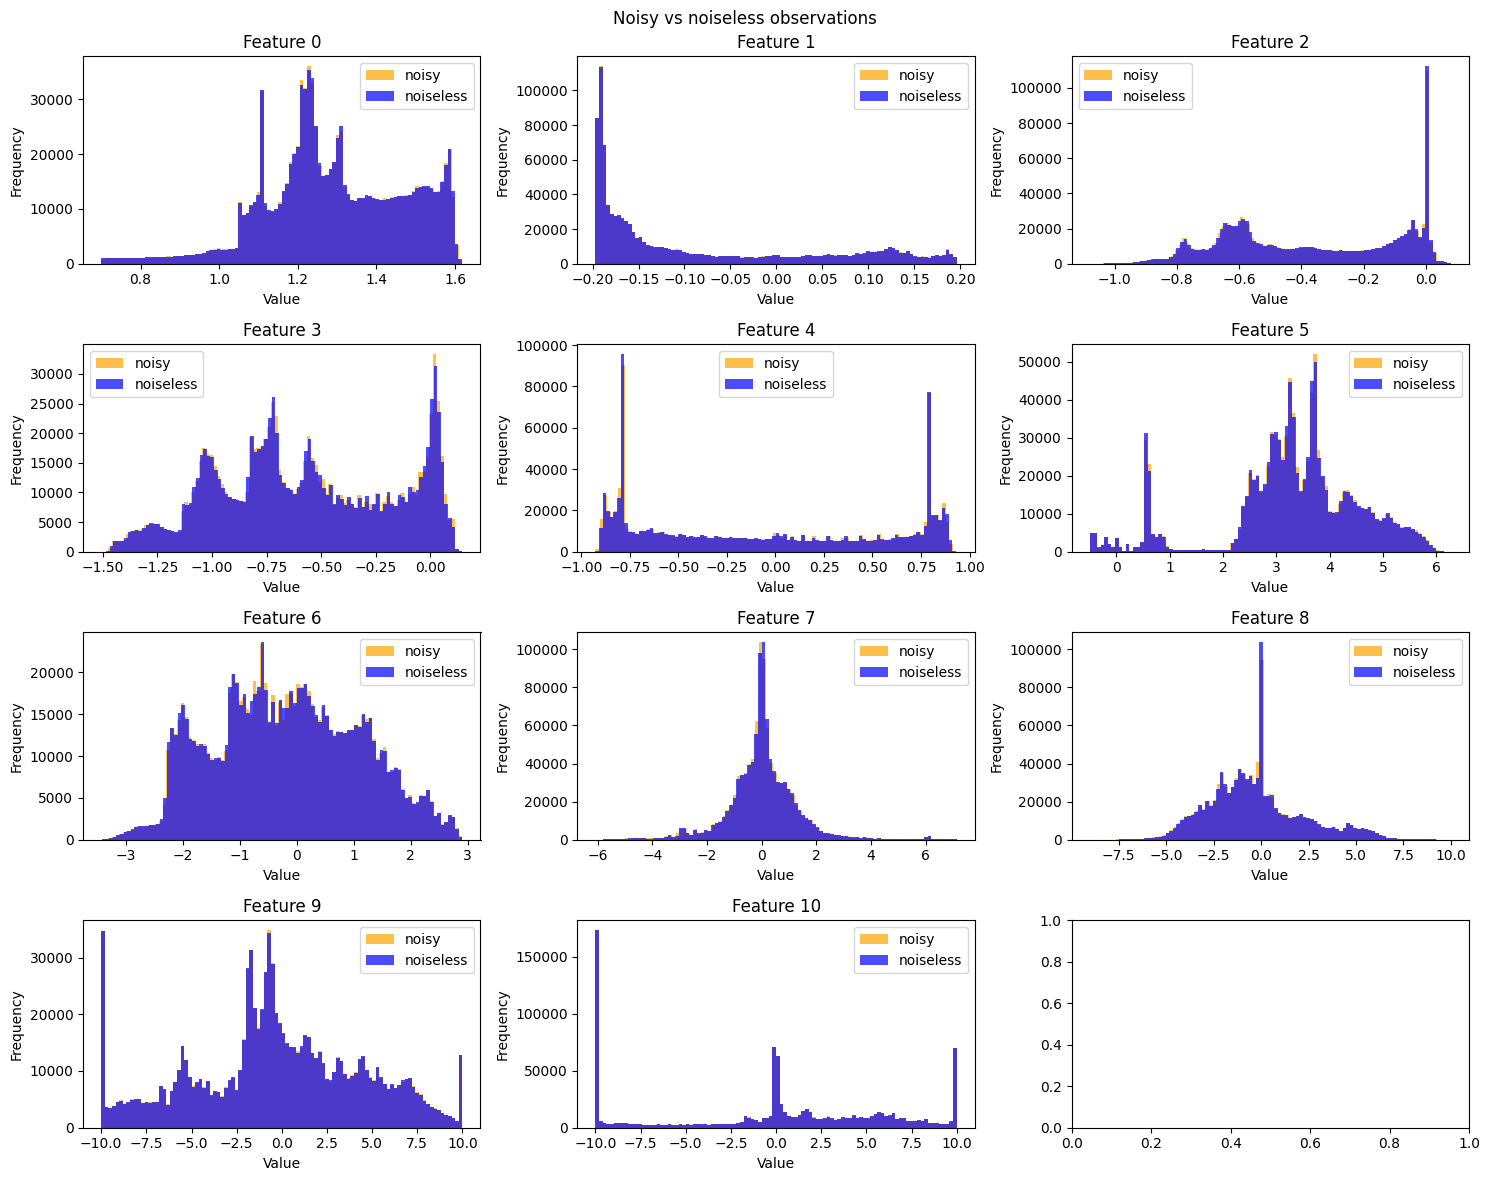

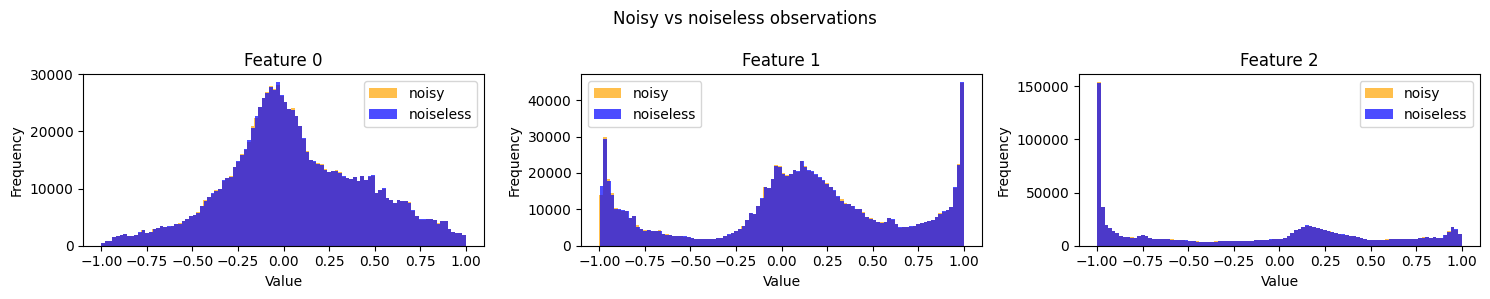

In [38]:
plot_features( data_noisy_001_1['observation'], data_no_noisy['observation'],title = 'Noisy vs noiseless observations')
plot_features(data_noisy_001_1['action'], data_no_noisy['action'], title = 'Noisy vs noiseless observations')

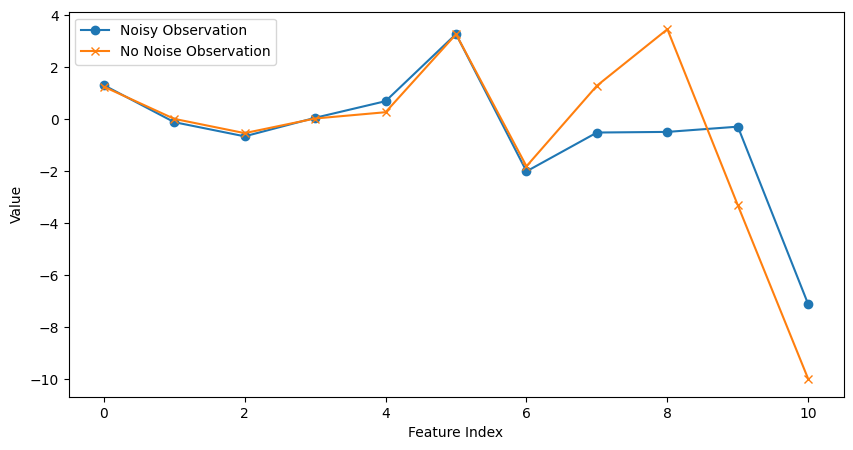

In [45]:

#plot one sample from the predicted next_observations ande eval_Data

sample_idx = 260
sample_pred = data_noisy_001_1['observation'][sample_idx]
sample_gt = data_no_noisy['observation'][sample_idx]
plt.figure(figsize=(10, 5))
plt.plot(sample_pred, label='Noisy Observation', marker='o')
plt.plot(sample_gt, label='No Noise Observation', marker='x')
# plt.title('Sample Predicted vs Ground Truth Next Observation')
plt.xlabel('Feature Index')
plt.ylabel('Value')
plt.legend()
plt.show()


## noise rate=1 noise magnitude=0.1

In [12]:

logdir = "/abiomed/intermediate_data_d4rl/sac_expert/Hopper-v2_action_noisy_added_0.1_1.0.pkl"
with open(logdir, 'rb') as f:
    data_noisy_01_1 = pickle.load(f)

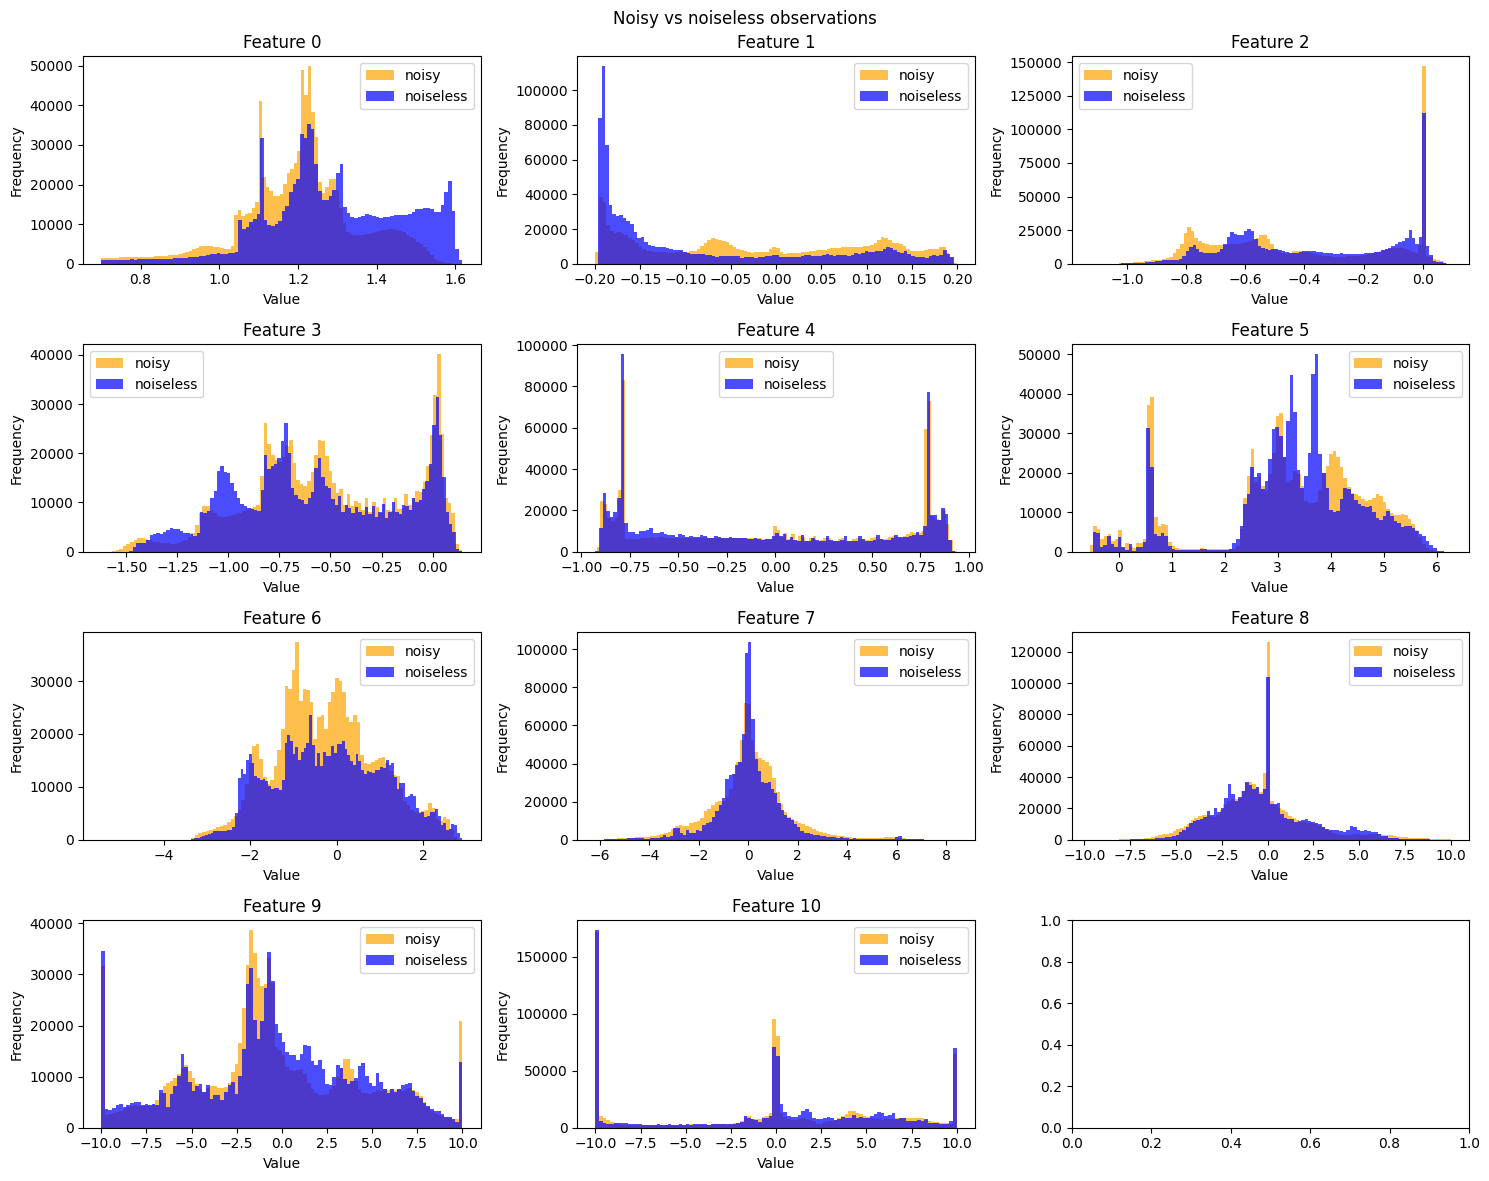

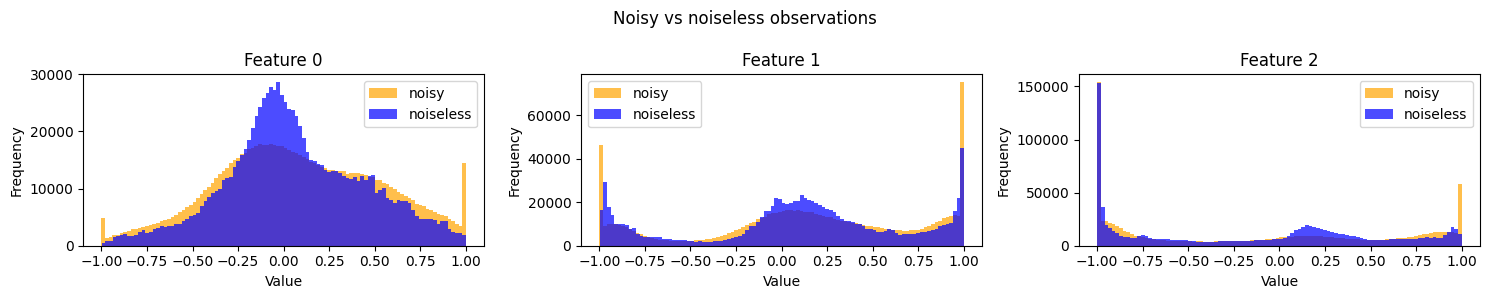

In [50]:
plot_features( data_noisy_01_1['observation'], data_no_noisy['observation'],title = 'Noisy vs noiseless observations')
plot_features(data_noisy_01_1['action'], data_no_noisy['action'], title = 'Noisy vs noiseless observations')

In [ ]:
#the rewards of expert policy -SAC, TQC

In [56]:
data_noisy_01_1

data_noisy_01_1['observations'] = data_noisy_01_1['observation']
data_noisy_01_1['actions'] = data_noisy_01_1['action']
data_noisy_01_1['next_observations'] = data_noisy_01_1['next_observation']
data_noisy_01_1['rewards'] = data_noisy_01_1['reward']
data_noisy_01_1['terminals'] = data_noisy_01_1['terminal']

#save
logdir = "/abiomed/intermediate_data_d4rl/sac_expert/Hopper-v2_action_noisy_added_0.1_1.0.pkl"
with open(logdir, 'wb') as f:
    pickle.dump(data_noisy_01_1, f)



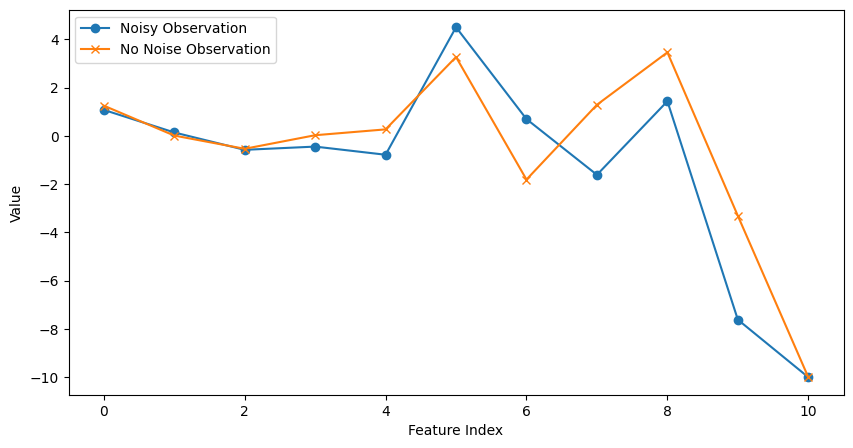

In [51]:

#plot one sample from the predicted next_observations ande eval_Data

sample_idx = 260
sample_pred = data_noisy_01_1['observation'][sample_idx]
sample_gt = data_no_noisy['observation'][sample_idx]
plt.figure(figsize=(10, 5))
plt.plot(sample_pred, label='Noisy Observation', marker='o')
plt.plot(sample_gt, label='No Noise Observation', marker='x')
# plt.title('Sample Predicted vs Ground Truth Next Observation')
plt.xlabel('Feature Index')
plt.ylabel('Value')
plt.legend()
plt.show()


In [52]:

logdir = "/abiomed/intermediate_data_d4rl/sac_expert/Hopper-v2_action_noisy_added_0.5_1.0.pkl"
with open(logdir, 'rb') as f:
    data_noisy_05_1 = pickle.load(f)

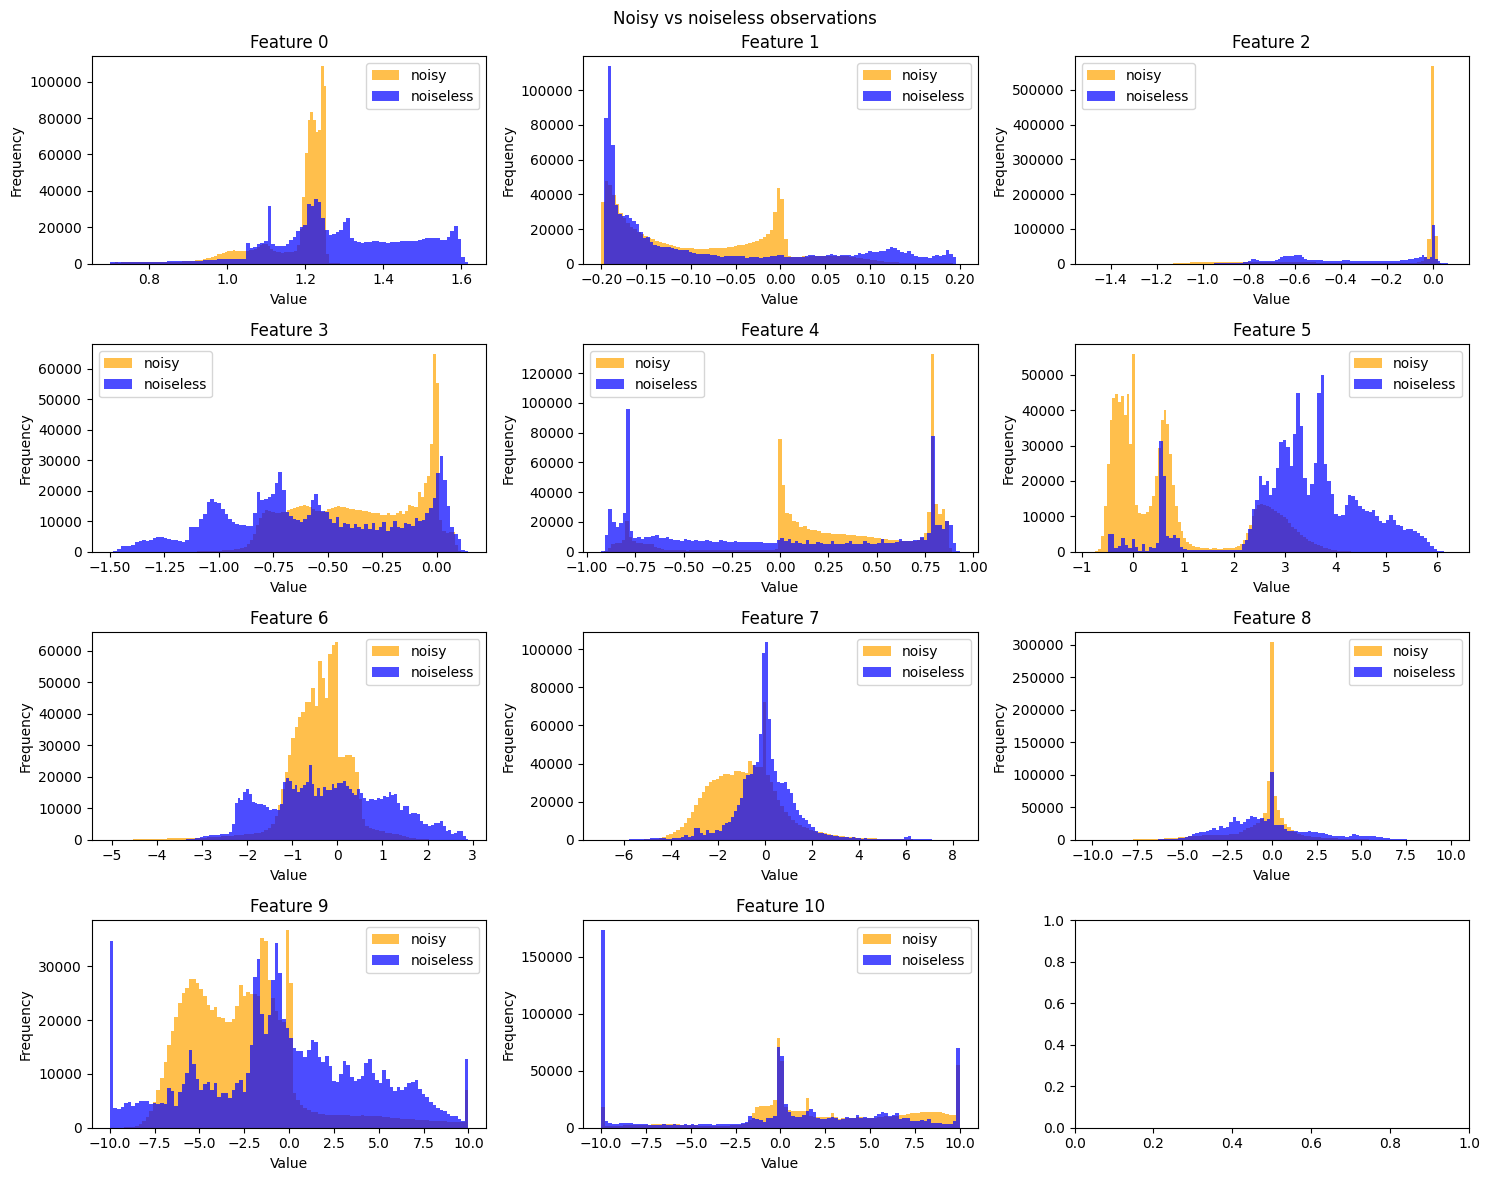

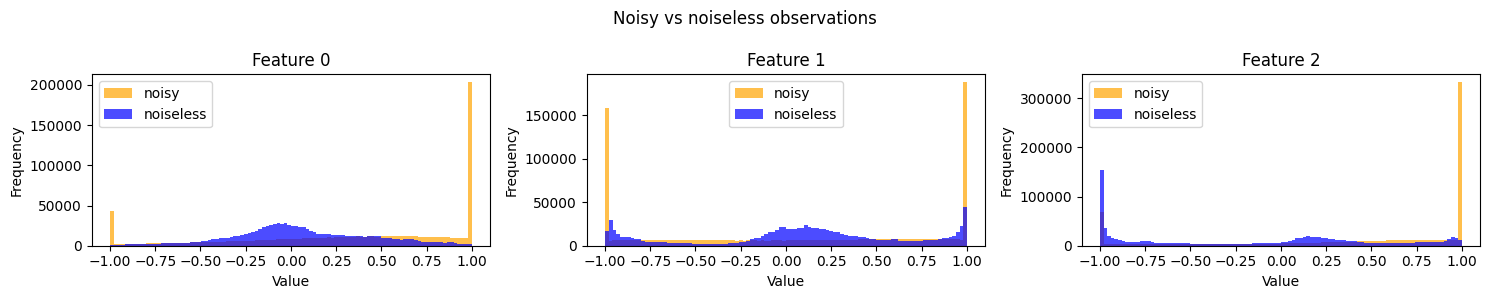

In [53]:
plot_features( data_noisy_05_1['observation'], data_no_noisy['observation'],title = 'Noisy vs noiseless observations')
plot_features(data_noisy_05_1['action'], data_no_noisy['action'], title = 'Noisy vs noiseless observations')

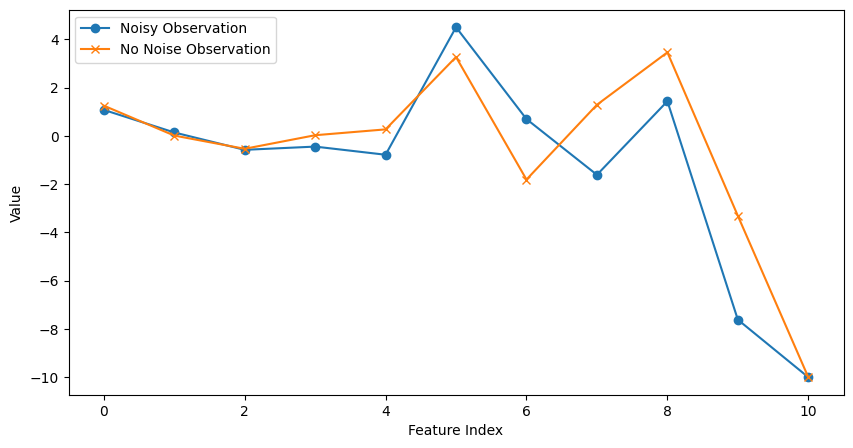

In [54]:

#plot one sample from the predicted next_observations ande eval_Data

sample_idx = 260
sample_pred = data_noisy_01_1['observation'][sample_idx]
sample_gt = data_no_noisy['observation'][sample_idx]
plt.figure(figsize=(10, 5))
plt.plot(sample_pred, label='Noisy Observation', marker='o')
plt.plot(sample_gt, label='No Noise Observation', marker='x')
# plt.title('Sample Predicted vs Ground Truth Next Observation')
plt.xlabel('Feature Index')
plt.ylabel('Value')
plt.legend()
plt.show()


In [11]:
logdir = "/abiomed/intermediate_data_d4rl/sac_expert/Hopper-v2_action_obs_noisy_0.1_1.0.pkl"
with open(logdir, 'rb') as f:
    data_noisy_01_1_tr = pickle.load(f)
plot_features( data_noisy_01_1_tr['observation'], data_no_noisy['observation'],title = 'Noisy vs noiseless observations')
plot_features(data_noisy_01_1_tr['action'], data_no_noisy['action'], title = 'Noisy vs noiseless observations')

NameError: name 'data_no_noisy' is not defined

In [9]:


data_noisy_01_1_tr['observations'] = data_noisy_01_1_tr['observation']
data_noisy_01_1_tr['actions'] = data_noisy_01_1_tr['action']
data_noisy_01_1_tr['next_observations'] = data_noisy_01_1_tr['next_observation']
data_noisy_01_1_tr['rewards'] = data_noisy_01_1_tr['reward']
data_noisy_01_1_tr['terminals'] = data_noisy_01_1_tr['terminal']

#save
logdir = "/abiomed/intermediate_data_d4rl/sac_expert/Hopper-v2_action_obs_noisy_0.1_1.0.pkl"
with open(logdir, 'wb') as f:
    pickle.dump(data_noisy_01_1_tr, f)



In [6]:

expert['observations'].shape



(918459, 11)

In [7]:
data['observations'].shape

(999061, 11)

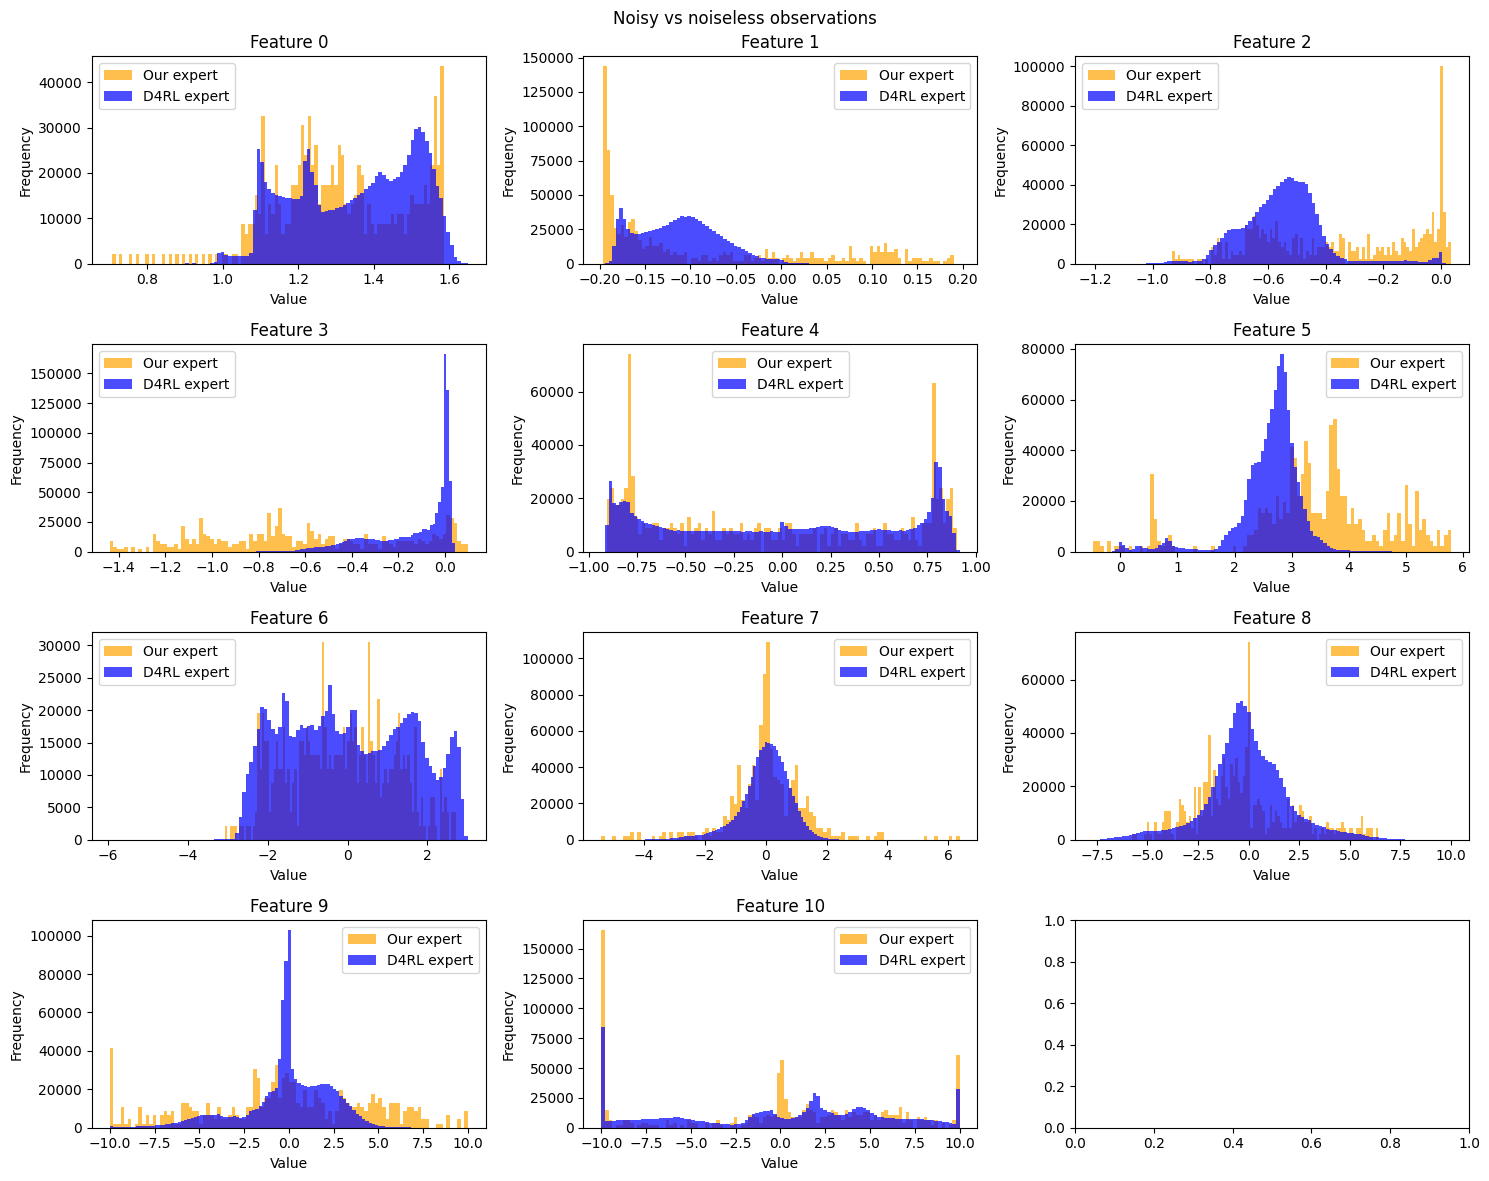

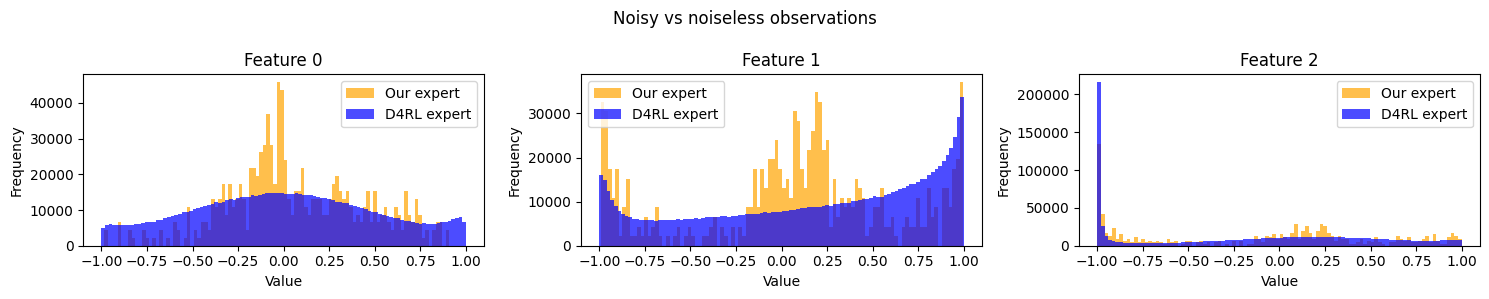

In [17]:

logdir = "/abiomed/intermediate_data_d4rl/sac_expert/Hopper-v3_expert_2200.pkl"
with open(logdir, 'rb') as f:
    expert_2200 = pickle.load(f)
plot_features( expert_2200['observations'], data['observations'],title = 'Noisy vs noiseless observations', label1='Our expert', label2='D4RL expert')
plot_features(expert_2200['actions'], data['actions'], title = 'Noisy vs noiseless observations', label1='Our expert', label2='D4RL expert')

In [18]:
expert_2200['observations'].shape


(999243, 11)

In [ ]:

logdir = "/abiomed/intermediate_data_d4rl/sac_expert/Hopper-v2_expert_2200.pkl"
with open(logdir, 'rb') as f:
    expert_2200 = pickle.load(f)
plot_features( expert_2200['observations'], data['observations'],title = 'Noisy vs noiseless observations')
plot_features(expert_2200['actions'], data['actions'], title = 'Noisy vs noiseless observations')

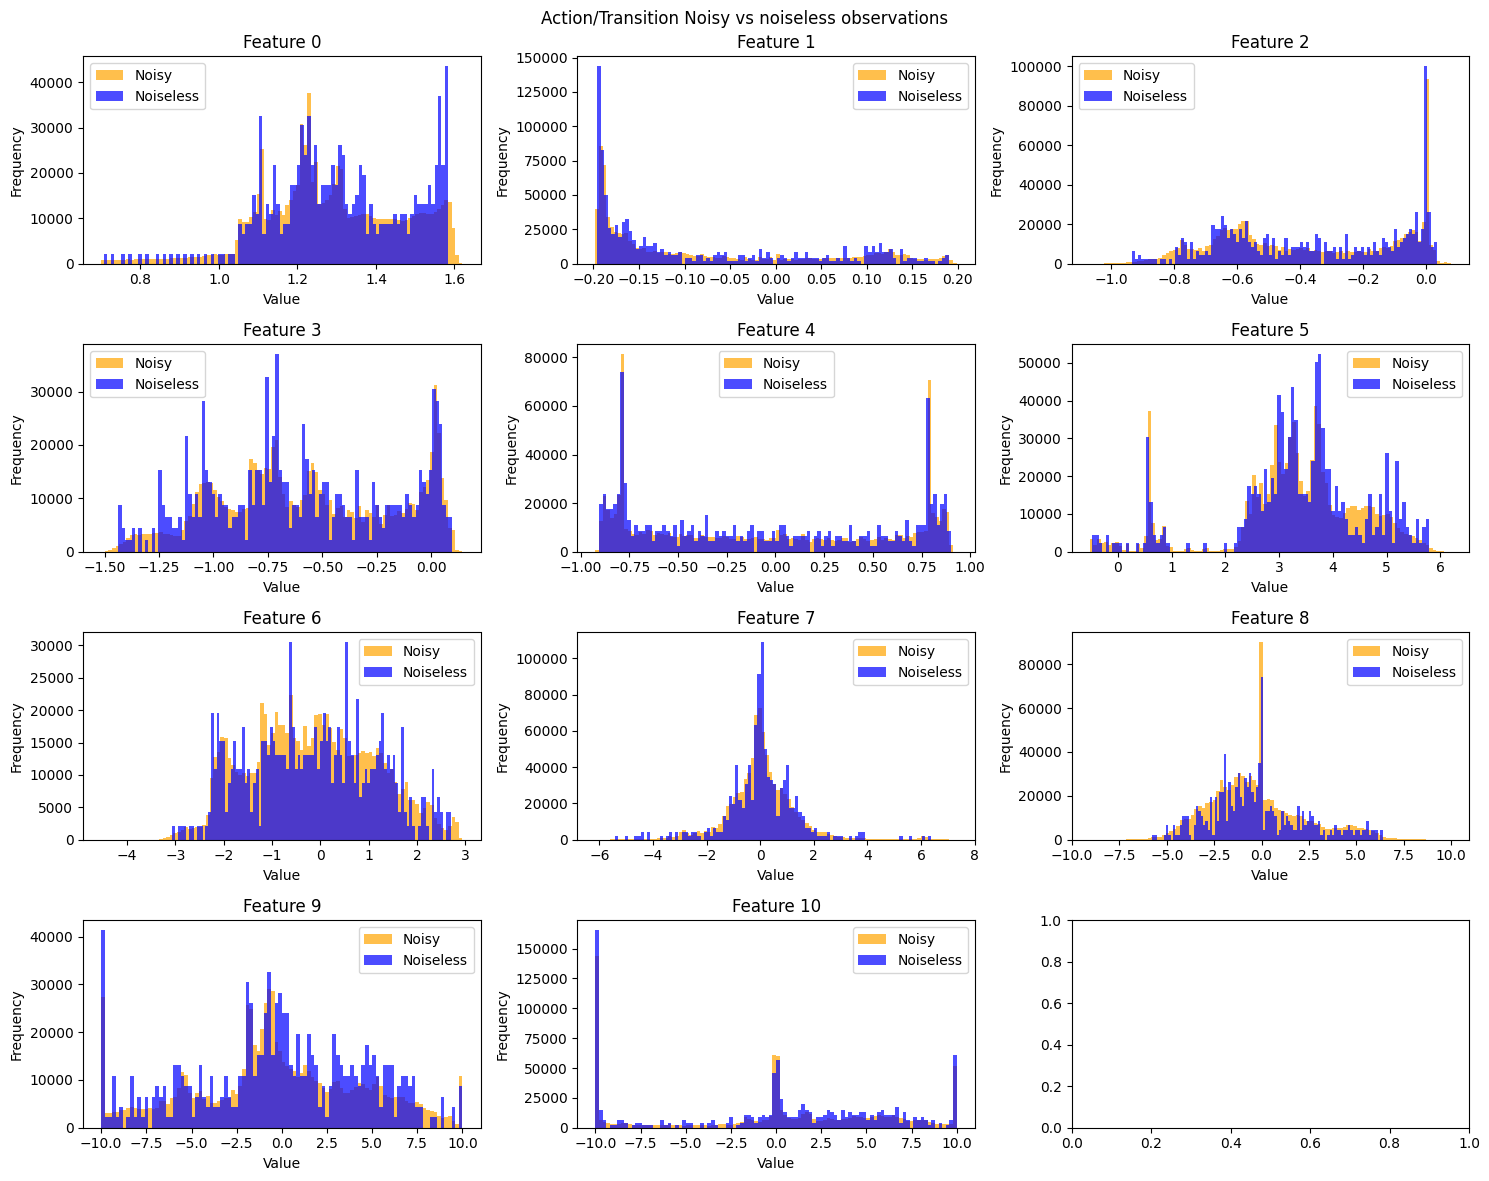

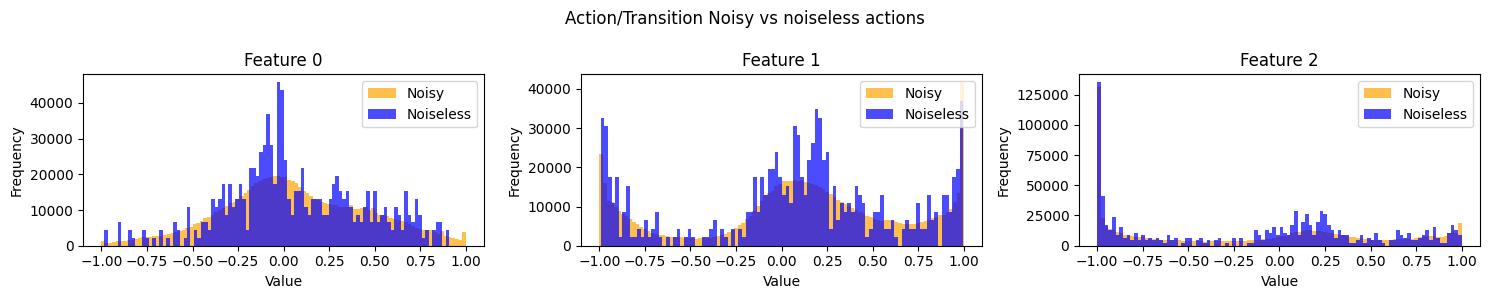

In [19]:
logdir = "/abiomed/intermediate_data_d4rl/sac_expert/Hopper-v3_action_obs_noisy_0.1_0.5.pkl"
with open(logdir, 'rb') as f:
    noisy_act_obs_01_05 = pickle.load(f)
plot_features( noisy_act_obs_01_05['observations'], expert_2200['observations'],title = 'Action/Transition Noisy vs noiseless observations', label1='Noisy', label2='Noiseless')
plot_features(noisy_act_obs_01_05['actions'], expert_2200['actions'], title = 'Action/Transition Noisy vs noiseless actions', label1='Noisy', label2='Noiseless')
